In [2]:
import codigo
from codigo import utils
from codigo import model_utils

In [3]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pickle import dump

%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importar Dataset depurado

In [4]:
df_Inicial = pd.read_csv(r'dataset/generado/datasetDepurado.csv')

# Revisamos las columnas que contiene el Dataset

In [5]:
df_Inicial.head()

ID                 Date  Glucose level
0  LIB193263  2020-06-09 19:08:00           99.0
1  LIB193263  2020-06-09 19:23:00           92.0
2  LIB193263  2020-06-09 19:38:00           86.0
3  LIB193263  2020-06-09 19:53:00           85.0
4  LIB193263  2020-06-09 20:08:00           85.0

In [6]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ID             object 
 1   Date           object 
 2   Glucose level  float64
dtypes: float64(1), object(2)
memory usage: 67.9+ MB


### Cambiamos el formato de la columna Date de object a datetime64

In [7]:
df_Inicial['Date']=pd.to_datetime(df_Inicial['Date'])

In [8]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ID             object        
 1   Date           datetime64[ns]
 2   Glucose level  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.9+ MB


In [9]:
df_Inicial['Date'].min()

Timestamp('2018-01-06 00:31:00')

In [10]:
df_Inicial['Date'].max()

Timestamp('2022-03-20 23:58:00')

# Seleccionar los pacientes para evaluación

In [11]:
dfPacienteCount= pd.DataFrame(df_Inicial.ID.value_counts().sort_values(ascending=False))
dfPacienteCount.columns = ['Freq']
dfPacienteCount

Freq
LIB193277  114563
LIB193385  112924
LIB193307  104043
LIB193309   77285
LIB193367   76611
...           ...
LIB193366    1287
LIB193398    1253
LIB193283    1098
LIB193365    1057
LIB193321       2

[108 rows x 1 columns]

In [12]:
pacientesNoDeseados=['LIB193321']
dfPacienteCount=dfPacienteCount[~dfPacienteCount.index.isin(pacientesNoDeseados)]

In [13]:
dfPacienteCount

Freq
LIB193277  114563
LIB193385  112924
LIB193307  104043
LIB193309   77285
LIB193367   76611
...           ...
LIB193282    1808
LIB193366    1287
LIB193398    1253
LIB193283    1098
LIB193365    1057

[107 rows x 1 columns]

<AxesSubplot: >

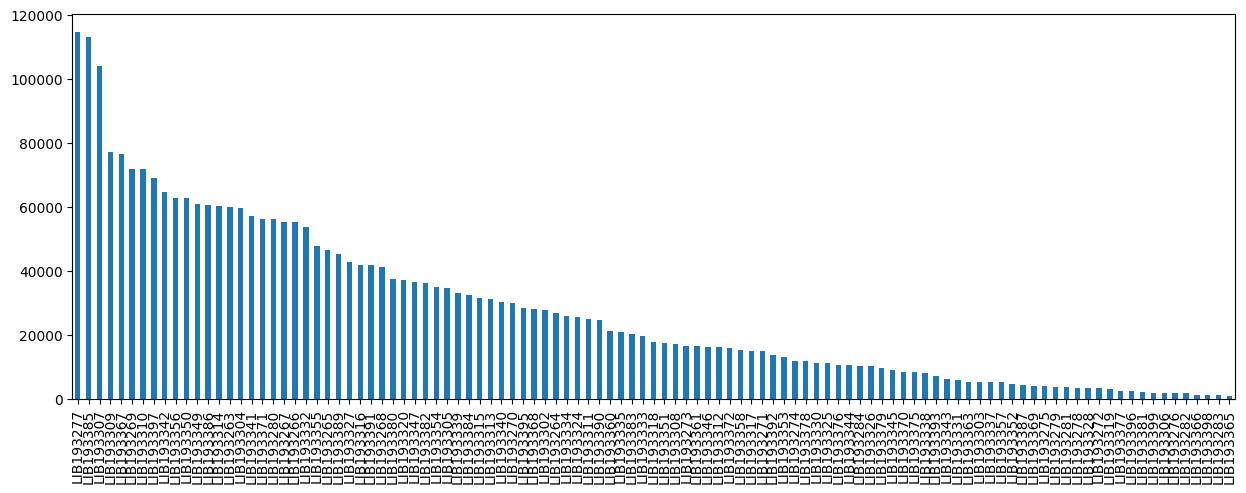

In [14]:
dfPacienteCount['Freq'].plot.bar(figsize=(15, 5))

In [15]:
dfPacienteCount.describe()

Freq
count     107.000000
mean    27726.009346
std     25694.131765
min      1057.000000
25%      6717.000000
50%     17889.000000
75%     41868.000000
max    114563.000000

In [16]:
train_share = 1
val_share = 0
lag=30
n_ahead=1
formato='%Y-%m-%d %H:%M:%S'
min=15

strMin=str(min)+'min'

In [17]:
features=['Glucose level','hour','min','pod_id','level_id','level_label']
featuresObj=['Glucose level','hour','min','pod_id','level_id']

In [18]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))
scalerHours = load(open('dataset/generado/scalerHours.scaler', 'rb'))
scalerMin = load(open('dataset/generado/scalerMin.scaler', 'rb'))
scalerPodId = load(open('dataset/generado/scalerPodId.scaler', 'rb'))
scalerLevelId = load(open('dataset/generado/scalerLevelId.scaler', 'rb'))

## Pacientes del Q1

In [19]:
dfPacienteCount[dfPacienteCount['Freq'].between(0, 6717)]

Freq
LIB193343  6323
LIB193331  6026
LIB193363  5362
LIB193303  5283
LIB193337  5187
LIB193357  5169
LIB193352  4775
LIB193387  4490
LIB193369  4170
LIB193275  4095
LIB193279  3676
LIB193281  3591
LIB193278  3521
LIB193328  3475
LIB193272  3436
LIB193319  3028
LIB193377  2622
LIB193396  2384
LIB193381  2089
LIB193399  1913
LIB193306  1905
LIB193276  1902
LIB193282  1808
LIB193366  1287
LIB193398  1253
LIB193283  1098
LIB193365  1057

'LIB193399' tiene 1913 muestras

In [20]:
ID_Paciente=pq1='LIB193399'


diasP1=[]
especialesP1=[]

In [21]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [22]:
dfpaciente

ID                Date  Glucose level
2964772  LIB193399 2020-09-30 18:15:00          105.0
2964773  LIB193399 2020-09-30 18:30:00          101.0
2964774  LIB193399 2020-09-30 18:45:00           98.0
2964775  LIB193399 2020-09-30 19:00:00           99.0
2964776  LIB193399 2020-09-30 19:15:00          108.0
...            ...                 ...            ...
2966680  LIB193399 2020-10-20 20:50:00           83.0
2966681  LIB193399 2020-10-20 21:05:00           76.0
2966682  LIB193399 2020-10-20 21:20:00           67.0
2966683  LIB193399 2020-10-20 21:35:00           63.0
2966684  LIB193399 2020-10-20 21:50:00           63.0

[1913 rows x 3 columns]

In [23]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [24]:
dfGenPaciente

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-09-30 18:15:00          105.0    18   15       4         0    euglycemia
2020-09-30 18:30:00          101.0    18   30       4         0    euglycemia
2020-09-30 18:45:00           98.0    18   45       4         0    euglycemia
2020-09-30 19:00:00           99.0    19    0       4         0    euglycemia
2020-09-30 19:15:00          108.0    19   15       4         0    euglycemia
...                            ...   ...  ...     ...       ...           ...
2020-10-20 20:45:00           83.0    20   45       4         0    euglycemia
2020-10-20 21:00:00           76.0    21    0       5         0    euglycemia
2020-10-20 21:15:00           67.0    21   15       5        -1  hypoglycemia
2020-10-20 21:30:00           63.0    21   30       5        -1  hypoglycemia
2020-10-20 21:45:00           63.0    21   45       5        -1  hypoglycemia

[1935 rows x 6 columns]

In [25]:
dfGenPacienteScaled

Glucose level      hour       min  pod_id  level_id
Date                                                                    
2020-09-30 18:15:00       0.141304  0.782609  0.254237     0.6       0.5
2020-09-30 18:30:00       0.132609  0.782609  0.508475     0.6       0.5
2020-09-30 18:45:00       0.126087  0.782609  0.762712     0.6       0.5
2020-09-30 19:00:00       0.128261  0.826087  0.000000     0.6       0.5
2020-09-30 19:15:00       0.147826  0.826087  0.254237     0.6       0.5
...                            ...       ...       ...     ...       ...
2020-10-20 20:45:00       0.093478  0.869565  0.762712     0.6       0.5
2020-10-20 21:00:00       0.078261  0.913043  0.000000     0.8       0.5
2020-10-20 21:15:00       0.058696  0.913043  0.254237     0.8       0.0
2020-10-20 21:30:00       0.050000  0.913043  0.508475     0.8       0.0
2020-10-20 21:45:00       0.050000  0.913043  0.762712     0.8       0.0

[1935 rows x 5 columns]

### Análisis del Paciente 1: ID: LIB193399

<AxesSubplot: ylabel='level_label'>

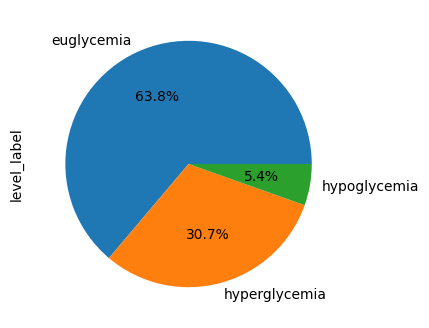

In [26]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-15 20:30:00
Rango Inicio Objetivo: 2020-10-16 04:00:00
Rango Fin Objetivo   : 2020-10-16 23:59:59


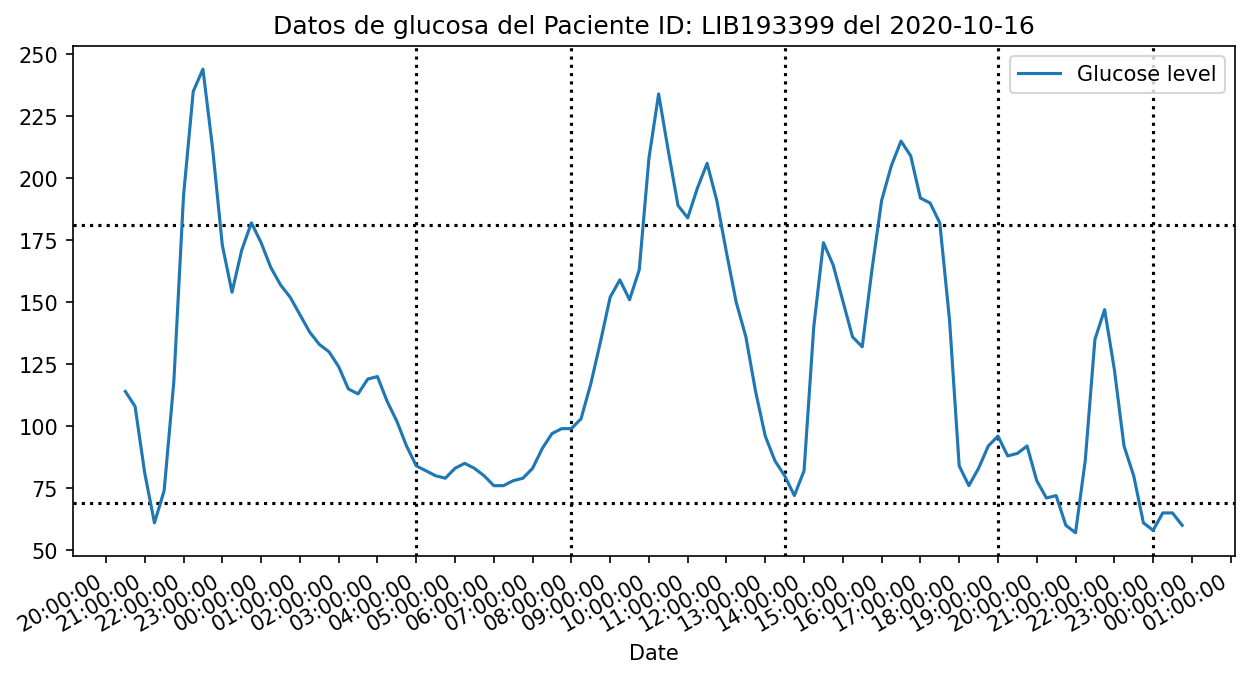

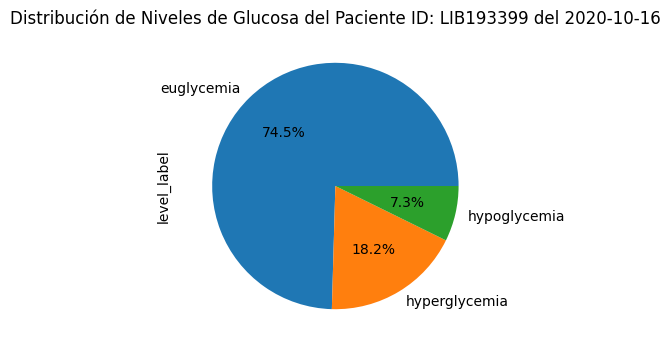

In [27]:
dateObj='2020-10-16'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP1_d1=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [30]:
df_rango.loc[dateObj+' 20:00:00':dateObj+' 21:30:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-10-16 20:00:00           78.0    20    0       4         0    euglycemia
2020-10-16 20:15:00           71.0    20   15       4         0    euglycemia
2020-10-16 20:30:00           72.0    20   30       4         0    euglycemia
2020-10-16 20:45:00           60.0    20   45       4        -1  hypoglycemia
2020-10-16 21:00:00           57.0    21    0       5        -1  hypoglycemia
2020-10-16 21:15:00           86.0    21   15       5         0    euglycemia
2020-10-16 21:30:00          135.0    21   30       5         0    euglycemia

In [31]:
especialesP1.append('2020-10-16 20:45:00')

### Selección del Dia 2 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-02 20:30:00
Rango Inicio Objetivo: 2020-10-3 04:00:00
Rango Fin Objetivo   : 2020-10-3 23:59:59


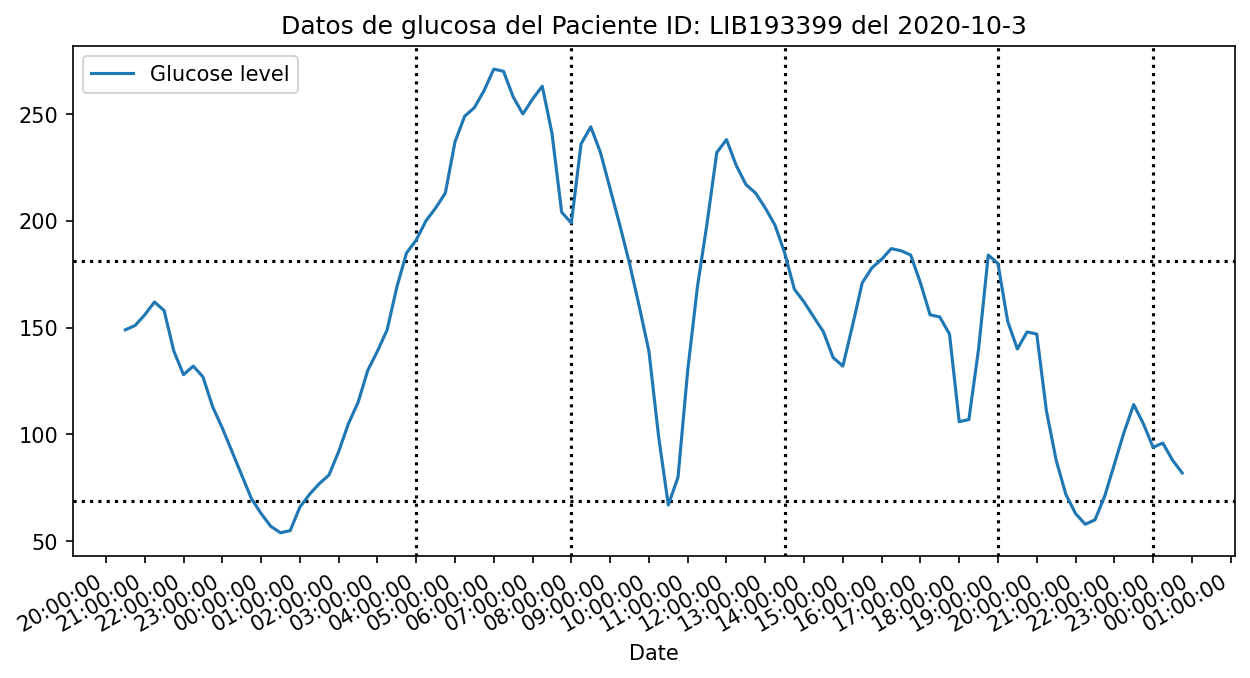

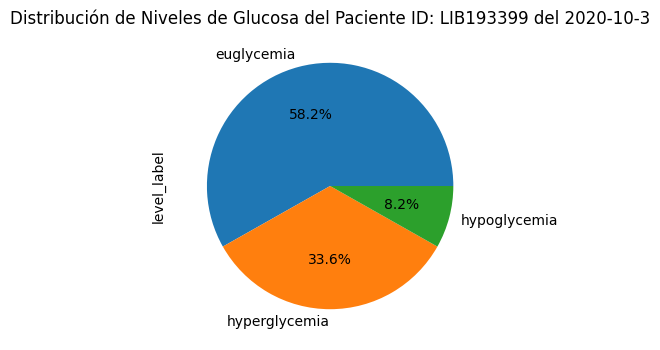

In [32]:
dateObj='2020-10-3'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP1_d2=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [34]:
df_rango.loc[dateObj+' 20:00:00':dateObj+' 23:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-10-03 20:00:00          147.0    20    0       4         0    euglycemia
2020-10-03 20:15:00          111.0    20   15       4         0    euglycemia
2020-10-03 20:30:00           88.0    20   30       4         0    euglycemia
2020-10-03 20:45:00           72.0    20   45       4         0    euglycemia
2020-10-03 21:00:00           63.0    21    0       5        -1  hypoglycemia
2020-10-03 21:15:00           58.0    21   15       5        -1  hypoglycemia
2020-10-03 21:30:00           60.0    21   30       5        -1  hypoglycemia
2020-10-03 21:45:00           71.0    21   45       5         0    euglycemia
2020-10-03 22:00:00           86.0    22    0       5         0    euglycemia
2020-10-03 22:15:00          101.0    22   15       5         0    euglycemia
2020-10-03 22:30:00          114.0    22   30       5         0    euglycemia
2020-10-03 22:45:00          105.0    22   45       5         0    euglycemia
2020-10-03 23:00:00           94.0    23    0       5         0    euglycemia

In [35]:
especialesP1.append('2020-10-03 21:00:00')

### Selección del Dia 3 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-09 20:30:00
Rango Inicio Objetivo: 2020-10-10 04:00:00
Rango Fin Objetivo   : 2020-10-10 23:59:59


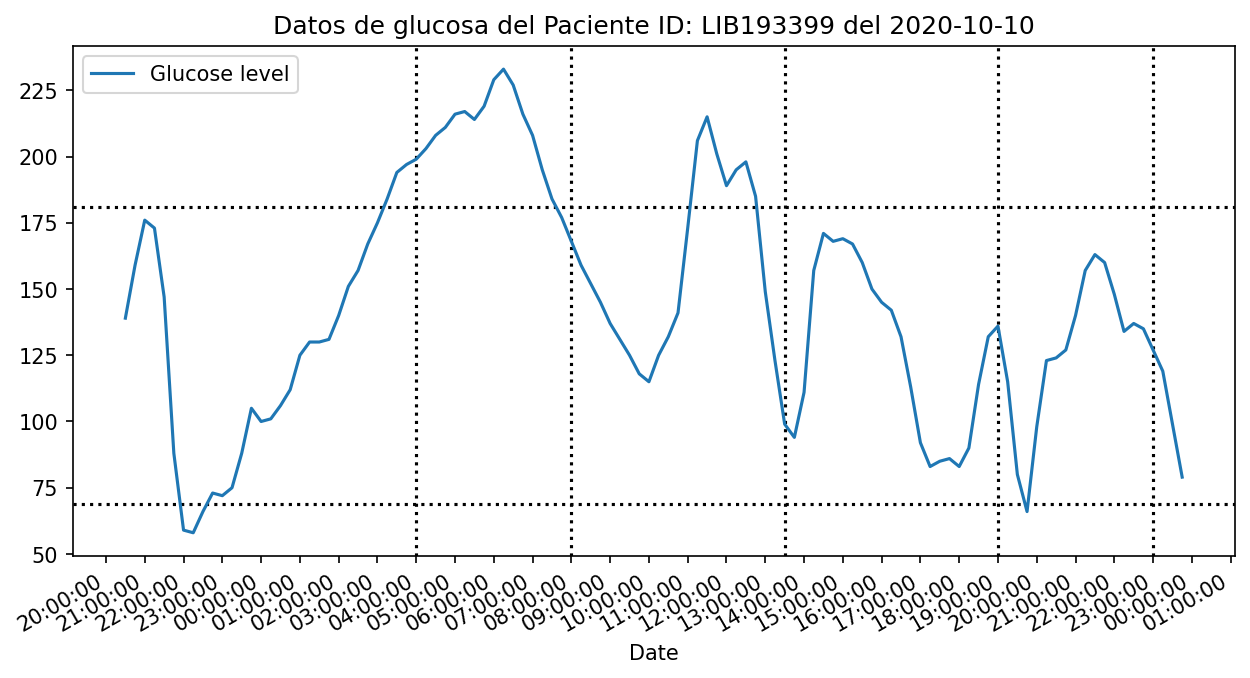

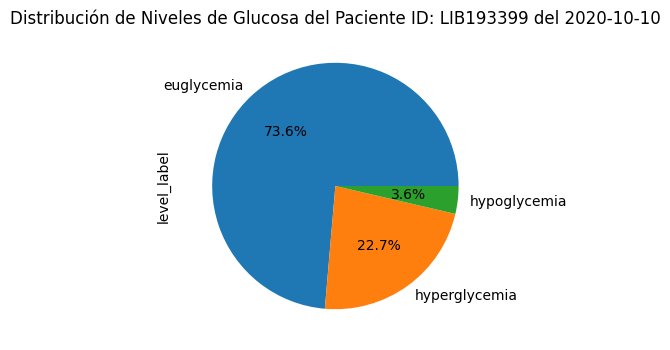

In [36]:
dateObj='2020-10-10'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP1_d3=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [33]:
df_rango.loc[dateObj+' 19:00:00':dateObj+' 20:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-10-10 19:00:00          136.0    19    0       4         0    euglycemia
2020-10-10 19:15:00          115.0    19   15       4         0    euglycemia
2020-10-10 19:30:00           80.0    19   30       4         0    euglycemia
2020-10-10 19:45:00           66.0    19   45       4        -1  hypoglycemia
2020-10-10 20:00:00           98.0    20    0       4         0    euglycemia

In [34]:
especialesP1.append('2020-10-10 19:45:00')

### Selección del Dia 4 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-11 20:30:00
Rango Inicio Objetivo: 2020-10-12 04:00:00
Rango Fin Objetivo   : 2020-10-12 23:59:59


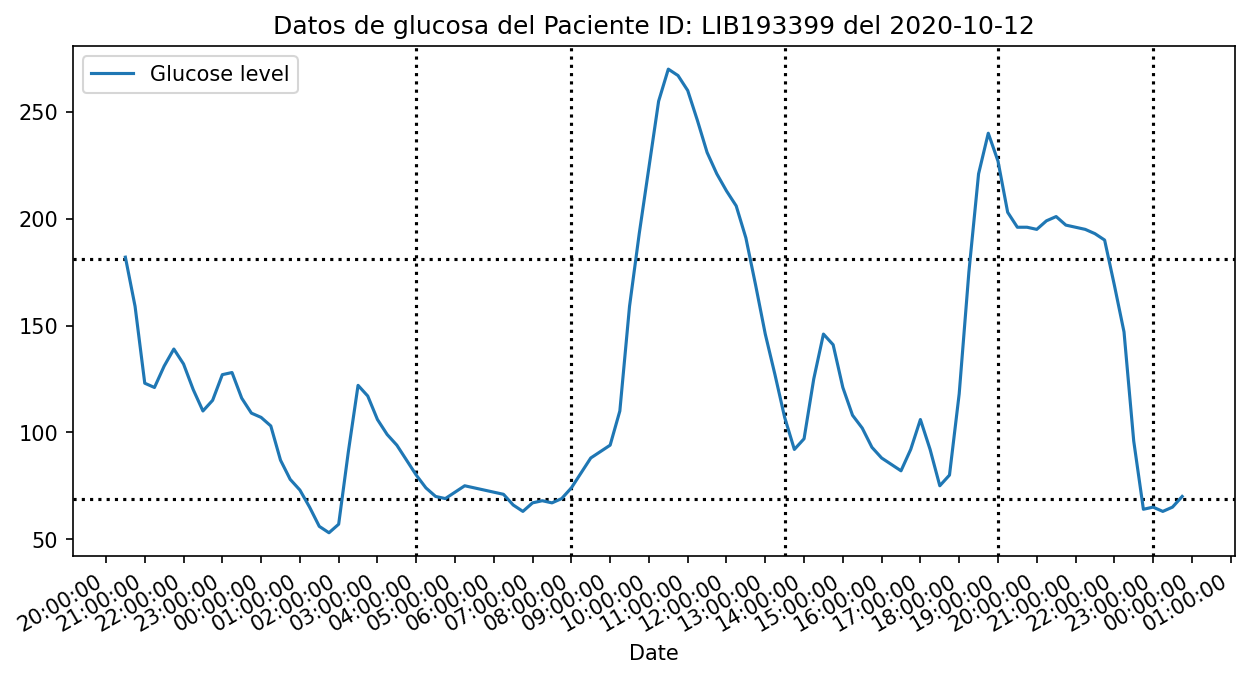

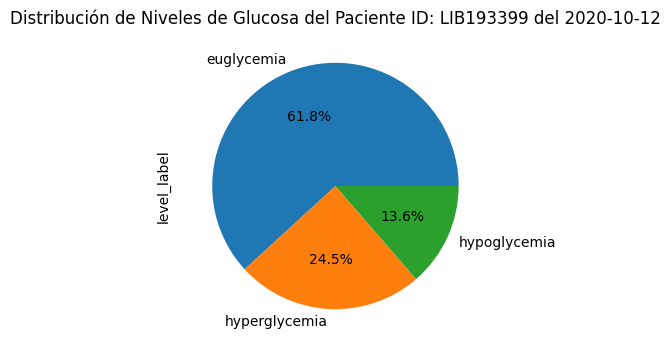

In [37]:
dateObj='2020-10-12'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP1_d4=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [39]:
df_rango.loc[dateObj+' 06:00:00':dateObj+' 08:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-10-12 06:00:00           72.0     6    0       1         0    euglycemia
2020-10-12 06:15:00           71.0     6   15       1         0    euglycemia
2020-10-12 06:30:00           66.0     6   30       1        -1  hypoglycemia
2020-10-12 06:45:00           63.0     6   45       1        -1  hypoglycemia
2020-10-12 07:00:00           67.0     7    0       1        -1  hypoglycemia
2020-10-12 07:15:00           68.0     7   15       1        -1  hypoglycemia
2020-10-12 07:30:00           67.0     7   30       1        -1  hypoglycemia
2020-10-12 07:45:00           69.0     7   45       1        -1  hypoglycemia
2020-10-12 08:00:00           74.0     8    0       1         0    euglycemia

In [37]:
especialesP1.append('2020-10-12 06:30:00')

In [38]:
diasP1

['2020-10-16', '2020-10-3', '2020-10-10', '2020-10-12']

In [39]:
especialesP1

['2020-10-16 17:45:00',
 '2020-10-03 21:00:00',
 '2020-10-10 19:45:00',
 '2020-10-12 06:30:00']

## Pacientes del Q2

In [40]:
dfPacienteCount[dfPacienteCount['Freq'].between(6717,17889)]

Freq
LIB193318  17889
LIB193351  17599
LIB193308  17178
LIB193273  16575
LIB193361  16448
LIB193346  16213
LIB193312  16155
LIB193372  15782
LIB193358  15146
LIB193317  14896
LIB193271  14859
LIB193392  13627
LIB193353  13083
LIB193274  11804
LIB193378  11730
LIB193330  11306
LIB193325  11152
LIB193376  10683
LIB193344  10465
LIB193284  10296
LIB193326  10291
LIB193379   9675
LIB193345   8894
LIB193370   8478
LIB193375   8319
LIB193338   8050
LIB193393   7111

'LIB193353' tiene 13083 muestras

In [61]:
ID_Paciente=pq2='LIB193353'


diasP2=[]
especialesP2=[]

In [62]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [63]:
dfpaciente

ID                Date  Glucose level
1967092  LIB193353 2021-04-20 18:25:00          180.0
1967093  LIB193353 2021-04-20 18:40:00          176.0
1967094  LIB193353 2021-04-20 18:55:00          178.0
1967095  LIB193353 2021-04-20 19:11:00          180.0
1967096  LIB193353 2021-04-20 19:25:00          172.0
...            ...                 ...            ...
1980170  LIB193353 2021-10-19 10:15:00          116.0
1980171  LIB193353 2021-10-19 10:30:00          117.0
1980172  LIB193353 2021-10-19 10:45:00          114.0
1980173  LIB193353 2021-10-19 11:00:00          101.0
1980174  LIB193353 2021-10-19 11:15:00           89.0

[13083 rows x 3 columns]

In [64]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [65]:
dfGenPaciente

Glucose level  hour  min  pod_id  level_id level_label
Date                                                                       
2021-04-20 18:15:00          180.0    18   15       4         0  euglycemia
2021-04-20 18:30:00          176.0    18   30       4         0  euglycemia
2021-04-20 18:45:00          178.0    18   45       4         0  euglycemia
2021-04-20 19:00:00          180.0    19    0       4         0  euglycemia
2021-04-20 19:15:00          172.0    19   15       4         0  euglycemia
...                            ...   ...  ...     ...       ...         ...
2021-10-19 10:15:00          116.0    10   15       2         0  euglycemia
2021-10-19 10:30:00          117.0    10   30       2         0  euglycemia
2021-10-19 10:45:00          114.0    10   45       2         0  euglycemia
2021-10-19 11:00:00          101.0    11    0       2         0  euglycemia
2021-10-19 11:15:00           89.0    11   15       2         0  euglycemia

[17445 rows x 6 columns]

In [66]:
dfGenPacienteScaled

Glucose level      hour       min  pod_id  level_id
Date                                                                    
2021-04-20 18:15:00       0.304348  0.782609  0.254237     0.6       0.5
2021-04-20 18:30:00       0.295652  0.782609  0.508475     0.6       0.5
2021-04-20 18:45:00       0.300000  0.782609  0.762712     0.6       0.5
2021-04-20 19:00:00       0.304348  0.826087  0.000000     0.6       0.5
2021-04-20 19:15:00       0.286957  0.826087  0.254237     0.6       0.5
...                            ...       ...       ...     ...       ...
2021-10-19 10:15:00       0.165217  0.434783  0.254237     0.2       0.5
2021-10-19 10:30:00       0.167391  0.434783  0.508475     0.2       0.5
2021-10-19 10:45:00       0.160870  0.434783  0.762712     0.2       0.5
2021-10-19 11:00:00       0.132609  0.478261  0.000000     0.2       0.5
2021-10-19 11:15:00       0.106522  0.478261  0.254237     0.2       0.5

[17445 rows x 5 columns]

### Análisis del Paciente 2: ID: LIB193353

<AxesSubplot: ylabel='level_label'>

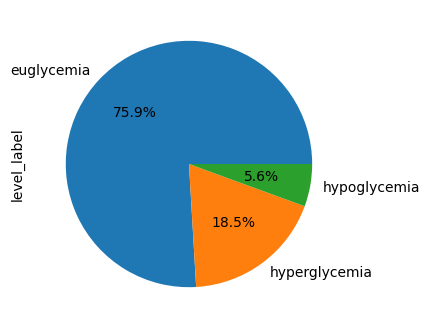

In [67]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 2: ID: LIB193353

Fecha Inicio Previo  : 2020-09-28 20:30:00
Rango Inicio Objetivo: 2020-09-29 04:00:00
Rango Fin Objetivo   : 2020-09-29 23:59:59


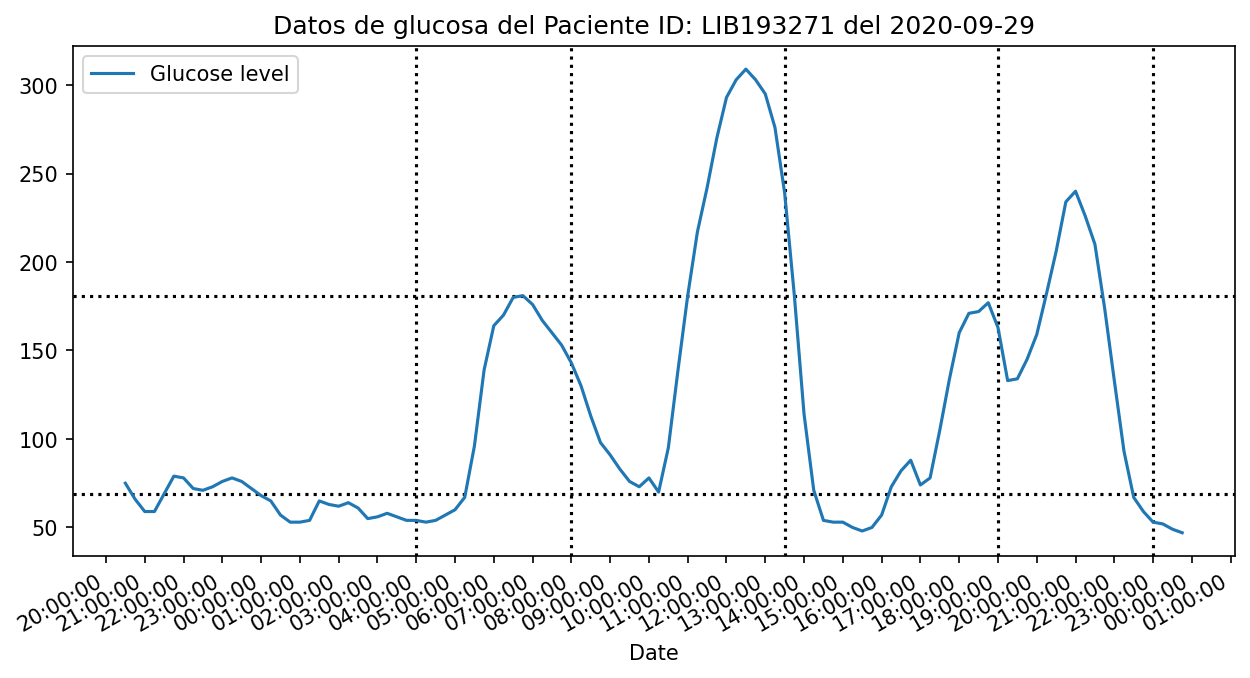

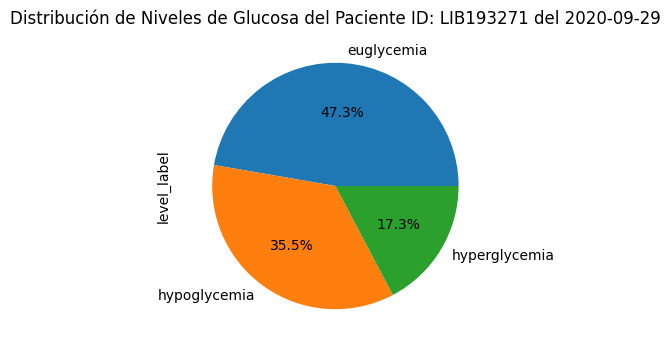

In [48]:
dateObj='2020-09-29'
diasP2.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP2_d1=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [49]:
df_rango.loc[dateObj+' 14:00:00':dateObj+' 15:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-09-29 14:00:00          114.0    14    0       3         0    euglycemia
2020-09-29 14:15:00           71.0    14   15       3         0    euglycemia
2020-09-29 14:30:00           54.0    14   30       3        -1  hypoglycemia
2020-09-29 14:45:00           53.0    14   45       3        -1  hypoglycemia
2020-09-29 15:00:00           53.0    15    0       3        -1  hypoglycemia

In [50]:
especialesP2.append('2020-09-29 14:30:00')

### Selección del Dia 2 del Paciente 2: ID: LIB193271

Fecha Inicio Previo  : 2020-10-10 20:30:00
Rango Inicio Objetivo: 2020-10-11 04:00:00
Rango Fin Objetivo   : 2020-10-11 23:59:59


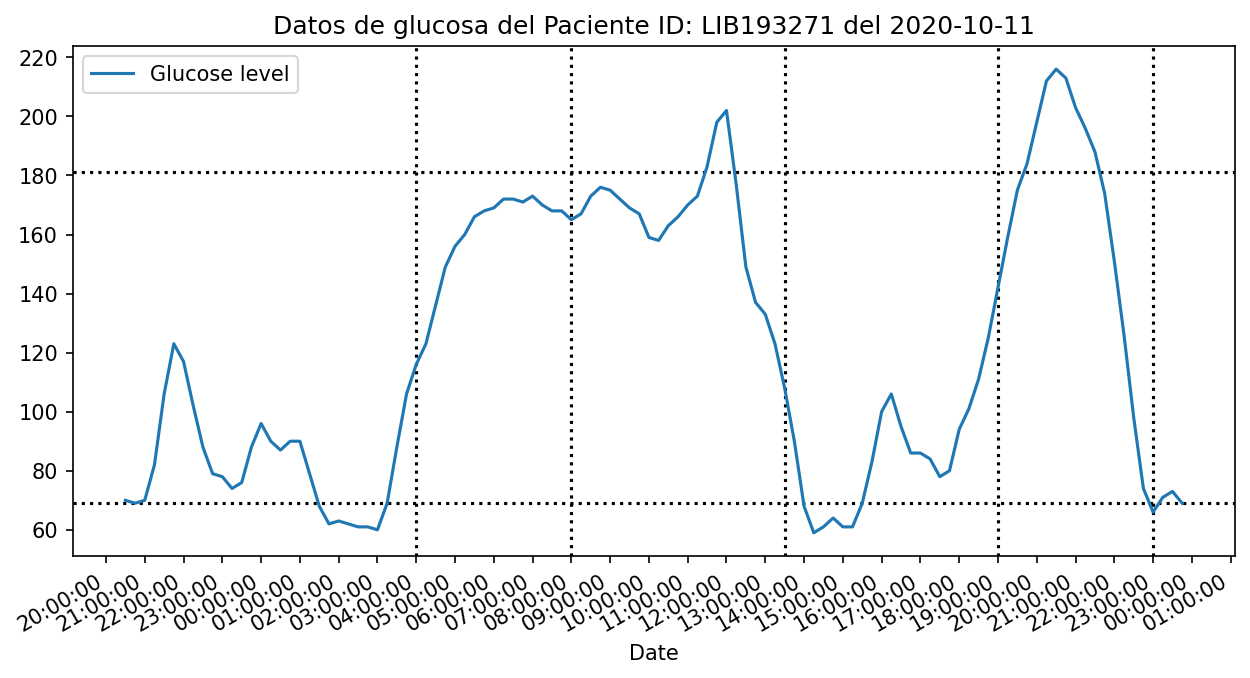

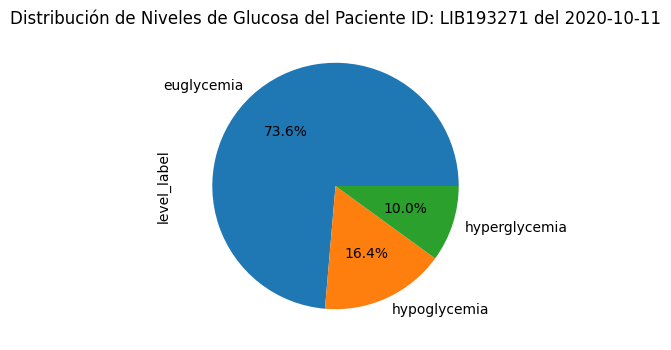

In [51]:
dateObj='2020-10-11'
diasP2.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP2_d2=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

In [52]:
dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd]

Glucose level      hour       min  pod_id  level_id
Date                                                                    
2020-10-10 20:30:00       0.065217  0.869565  0.508475     0.6       0.5
2020-10-10 20:45:00       0.063043  0.869565  0.762712     0.6       0.0
2020-10-10 21:00:00       0.065217  0.913043  0.000000     0.8       0.5
2020-10-10 21:15:00       0.091304  0.913043  0.254237     0.8       0.5
2020-10-10 21:30:00       0.143478  0.913043  0.508475     0.8       0.5
...                            ...       ...       ...     ...       ...
2020-10-11 22:45:00       0.073913  0.956522  0.762712     0.8       0.5
2020-10-11 23:00:00       0.056522  1.000000  0.000000     0.8       0.0
2020-10-11 23:15:00       0.067391  1.000000  0.254237     0.8       0.5
2020-10-11 23:30:00       0.071739  1.000000  0.508475     0.8       0.5
2020-10-11 23:45:00       0.063043  1.000000  0.762712     0.8       0.0

[110 rows x 5 columns]

### Agregamos eventos especiales de hipoglucemia

In [53]:
df_rango.loc[dateObj+' 13:00:00':dateObj+' 15:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-10-11 13:00:00          133.0    13    0       3         0    euglycemia
2020-10-11 13:15:00          123.0    13   15       3         0    euglycemia
2020-10-11 13:30:00          108.0    13   30       3         0    euglycemia
2020-10-11 13:45:00           90.0    13   45       3         0    euglycemia
2020-10-11 14:00:00           68.0    14    0       3        -1  hypoglycemia
2020-10-11 14:15:00           59.0    14   15       3        -1  hypoglycemia
2020-10-11 14:30:00           61.0    14   30       3        -1  hypoglycemia
2020-10-11 14:45:00           64.0    14   45       3        -1  hypoglycemia
2020-10-11 15:00:00           61.0    15    0       3        -1  hypoglycemia

In [54]:
especialesP2.append('2020-10-11 14:00:00')

### Selección del Dia 3 del Paciente 2: ID: LIB193271

Fecha Inicio Previo  : 2020-10-12 20:30:00
Rango Inicio Objetivo: 2020-10-13 04:00:00
Rango Fin Objetivo   : 2020-10-13 23:59:59


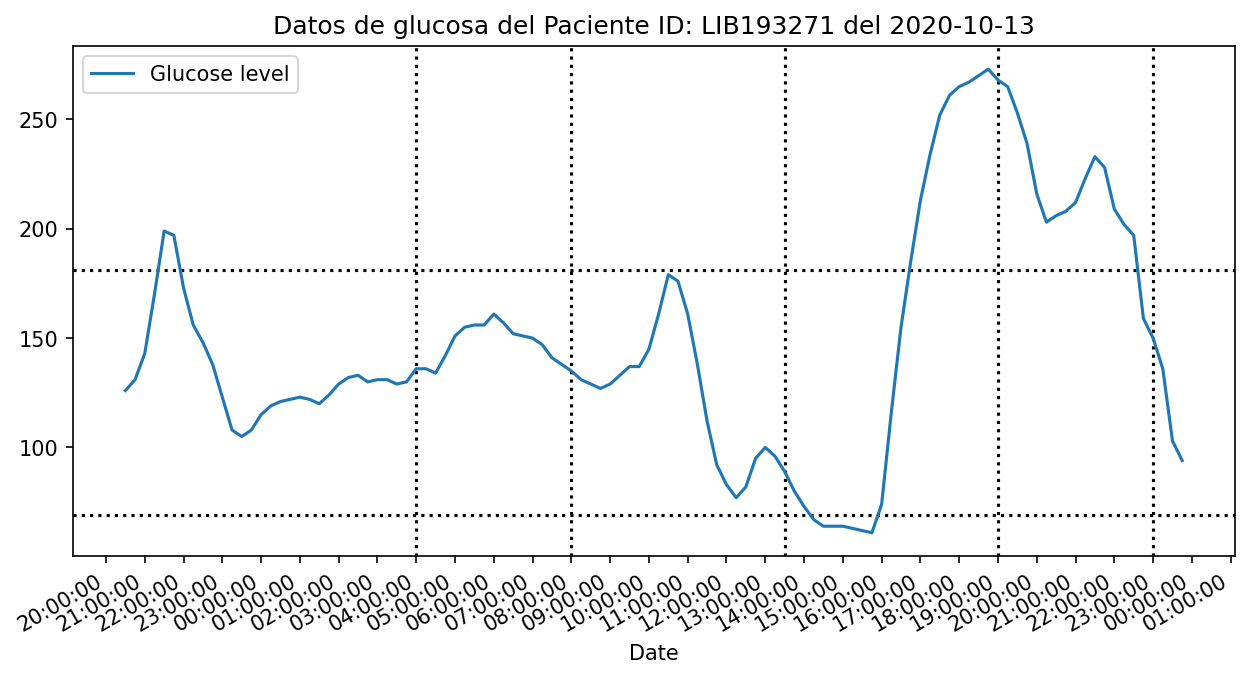

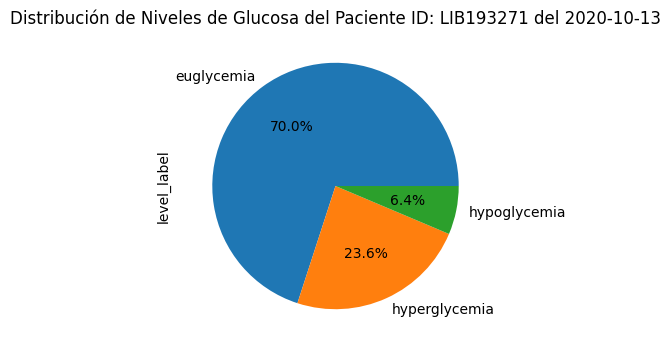

In [55]:
dateObj='2020-10-13'
diasP2.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP2_d3=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [56]:
df_rango.loc[dateObj+' 14:00:00':dateObj+' 15:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-10-13 14:00:00           73.0    14    0       3         0    euglycemia
2020-10-13 14:15:00           67.0    14   15       3        -1  hypoglycemia
2020-10-13 14:30:00           64.0    14   30       3        -1  hypoglycemia
2020-10-13 14:45:00           64.0    14   45       3        -1  hypoglycemia
2020-10-13 15:00:00           64.0    15    0       3        -1  hypoglycemia

In [57]:
especialesP2.append('2020-10-13 14:15:00')

### Selección del Dia 4 del Paciente 2: ID: LIB193271

Fecha Inicio Previo  : 2020-10-14 20:30:00
Rango Inicio Objetivo: 2020-10-15 04:00:00
Rango Fin Objetivo   : 2020-10-15 23:59:59


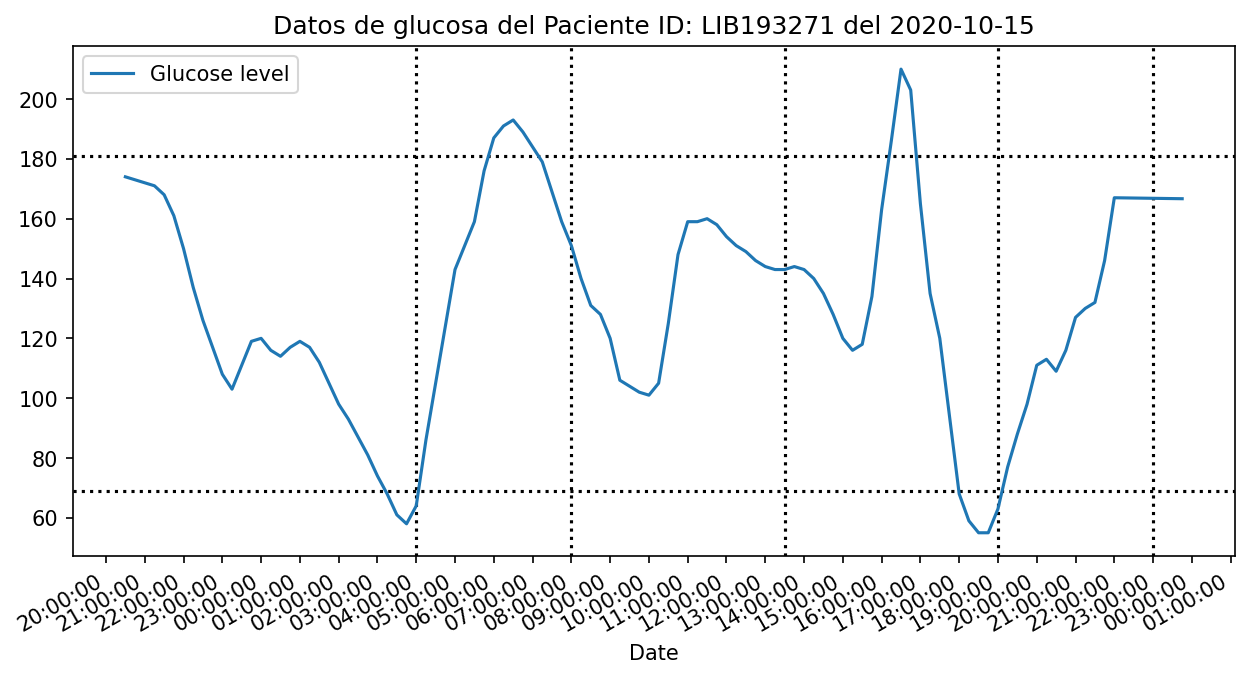

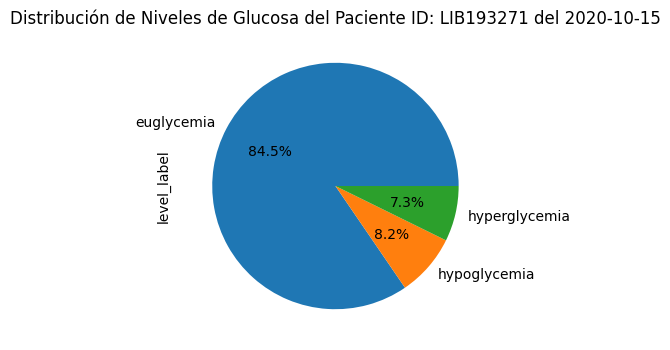

In [58]:
dateObj='2020-10-15'
diasP2.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP2_d4=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [59]:
df_rango.loc[dateObj+' 17:00:00':dateObj+' 18:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-10-15 17:00:00          165.0    17    0       4         0    euglycemia
2020-10-15 17:15:00          135.0    17   15       4         0    euglycemia
2020-10-15 17:30:00          120.0    17   30       4         0    euglycemia
2020-10-15 17:45:00           94.0    17   45       4         0    euglycemia
2020-10-15 18:00:00           68.0    18    0       4        -1  hypoglycemia

In [60]:
especialesP2.append('2020-10-15 18:00:00')

In [61]:
diasP2

['2020-09-29', '2020-10-11', '2020-10-13', '2020-10-15']

In [62]:
especialesP2

['2020-09-29 14:30:00',
 '2020-10-11 14:00:00',
 '2020-10-13 14:15:00',
 '2020-10-15 18:00:00']

## Pacientes del Q3

In [63]:
dfPacienteCount[dfPacienteCount['Freq'].between(17889,41868)]

Freq
LIB193391  41790
LIB193268  41073
LIB193380  37553
LIB193320  37172
LIB193347  36456
LIB193382  36130
LIB193354  35086
LIB193305  34549
LIB193339  33071
LIB193384  32368
LIB193315  31592
LIB193313  31188
LIB193340  30361
LIB193270  29980
LIB193395  28533
LIB193368  28188
LIB193302  27866
LIB193264  26787
LIB193334  25999
LIB193324  25517
LIB193311  25002
LIB193390  24796
LIB193360  21275
LIB193335  20900
LIB193383  20419
LIB193333  19658
LIB193318  17889

'LIB193315' tiene 31592 muestras

In [64]:
ID_Paciente=pq3='LIB193315'


diasP3=[]
especialesP3=[]

In [65]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [66]:
dfpaciente

ID                Date  Glucose level
1166570  LIB193315 2021-03-09 12:04:00           99.0
1166571  LIB193315 2021-03-09 12:19:00           89.0
1166572  LIB193315 2021-03-09 12:34:00           80.0
1166573  LIB193315 2021-03-09 12:49:00           87.0
1166574  LIB193315 2021-03-09 13:05:00          102.0
...            ...                 ...            ...
1198157  LIB193315 2022-03-18 06:11:00          188.0
1198158  LIB193315 2022-03-18 06:26:00          182.0
1198159  LIB193315 2022-03-18 06:41:00          171.0
1198160  LIB193315 2022-03-18 06:56:00          167.0
1198161  LIB193315 2022-03-18 07:11:00          166.0

[31592 rows x 3 columns]

In [67]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [68]:
dfGenPaciente

Glucose level  hour  min  pod_id  level_id    level_label
Date                                                                          
2021-03-09 12:00:00           99.0    12    0       2         0     euglycemia
2021-03-09 12:15:00           89.0    12   15       2         0     euglycemia
2021-03-09 12:30:00           80.0    12   30       2         0     euglycemia
2021-03-09 12:45:00           87.0    12   45       2         0     euglycemia
2021-03-09 13:00:00          102.0    13    0       3         0     euglycemia
...                            ...   ...  ...     ...       ...            ...
2022-03-18 06:00:00          188.0     6    0       1         1  hyperglycemia
2022-03-18 06:15:00          182.0     6   15       1         1  hyperglycemia
2022-03-18 06:30:00          171.0     6   30       1         0     euglycemia
2022-03-18 06:45:00          167.0     6   45       1         0     euglycemia
2022-03-18 07:00:00          166.0     7    0       1         0     euglycemia

[35885 rows x 6 columns]

In [69]:
dfGenPacienteScaled

Glucose level      hour       min  pod_id  level_id
Date                                                                    
2021-03-09 12:00:00       0.128261  0.521739  0.000000     0.2       0.5
2021-03-09 12:15:00       0.106522  0.521739  0.254237     0.2       0.5
2021-03-09 12:30:00       0.086957  0.521739  0.508475     0.2       0.5
2021-03-09 12:45:00       0.102174  0.521739  0.762712     0.2       0.5
2021-03-09 13:00:00       0.134783  0.565217  0.000000     0.4       0.5
...                            ...       ...       ...     ...       ...
2022-03-18 06:00:00       0.321739  0.260870  0.000000     0.0       1.0
2022-03-18 06:15:00       0.308696  0.260870  0.254237     0.0       1.0
2022-03-18 06:30:00       0.284783  0.260870  0.508475     0.0       0.5
2022-03-18 06:45:00       0.276087  0.260870  0.762712     0.0       0.5
2022-03-18 07:00:00       0.273913  0.304348  0.000000     0.0       0.5

[35885 rows x 5 columns]

### Análisis del Paciente 3: ID: LIB193315

<AxesSubplot: ylabel='level_label'>

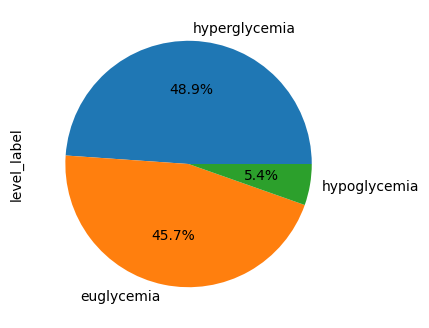

In [70]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 3: ID: LIB193315

Fecha Inicio Previo  : 2021-03-11 20:30:00
Rango Inicio Objetivo: 2021-03-12 04:00:00
Rango Fin Objetivo   : 2021-03-12 23:59:59


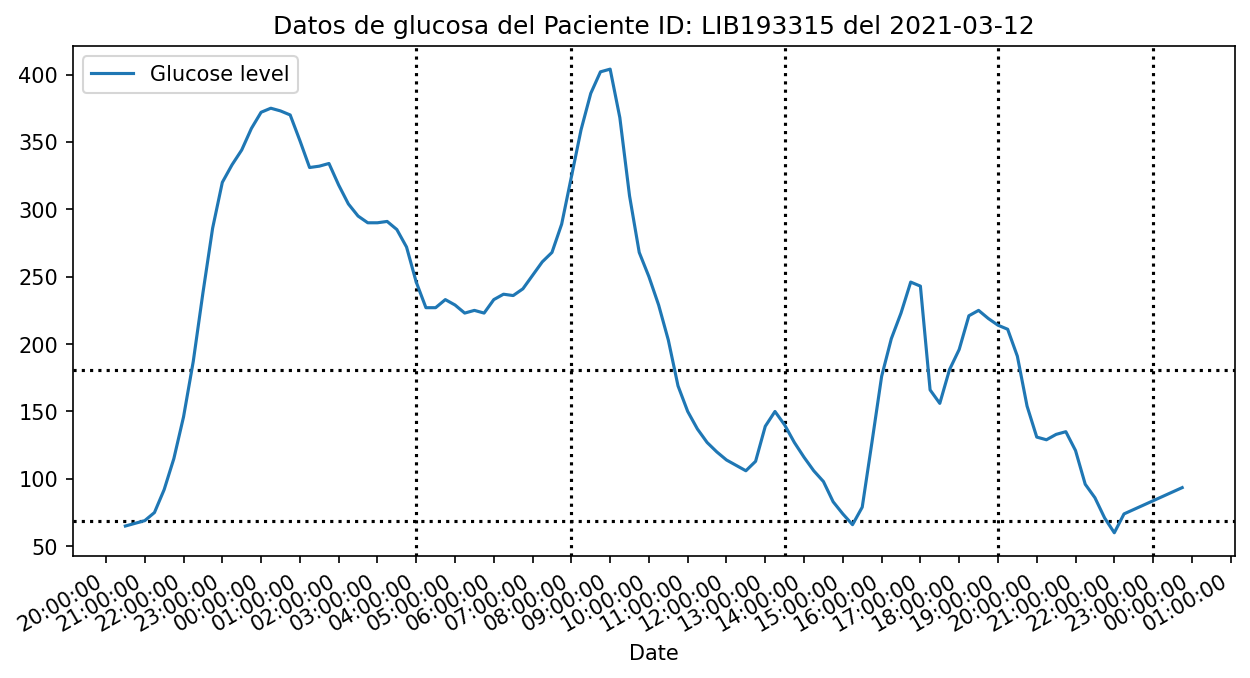

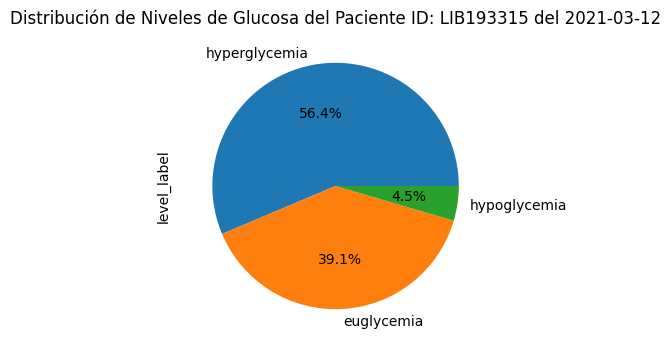

In [71]:
#dateObj='2021-03-13'
dateObj='2021-03-12'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP3_d1=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [72]:
df_rango.loc[dateObj+' 21:00:00':dateObj+' 22:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2021-03-12 21:00:00          121.0    21    0       5         0    euglycemia
2021-03-12 21:15:00           96.0    21   15       5         0    euglycemia
2021-03-12 21:30:00           86.0    21   30       5         0    euglycemia
2021-03-12 21:45:00           71.0    21   45       5         0    euglycemia
2021-03-12 22:00:00           60.0    22    0       5        -1  hypoglycemia

In [73]:
especialesP3.append('2021-03-12 22:00:00')

### Selección del Dia 2 del Paciente 3: ID: LIB193315

Fecha Inicio Previo  : 2021-05-19 20:30:00
Rango Inicio Objetivo: 2021-05-20 04:00:00
Rango Fin Objetivo   : 2021-05-20 23:59:59


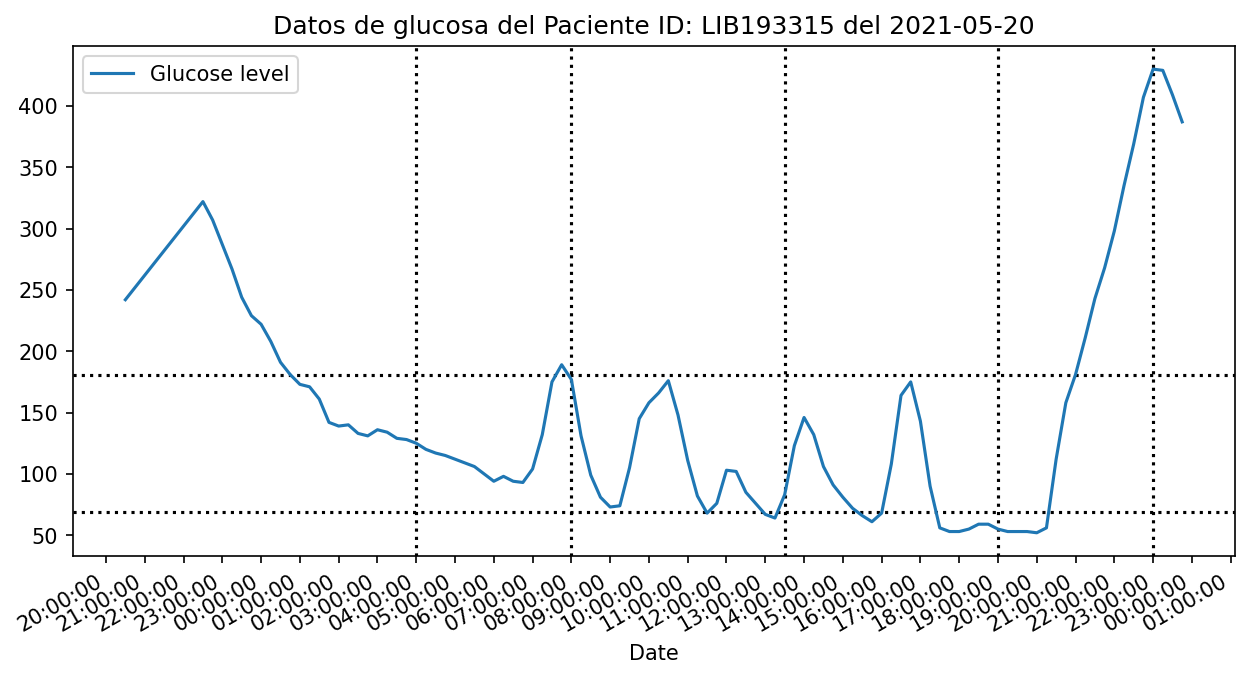

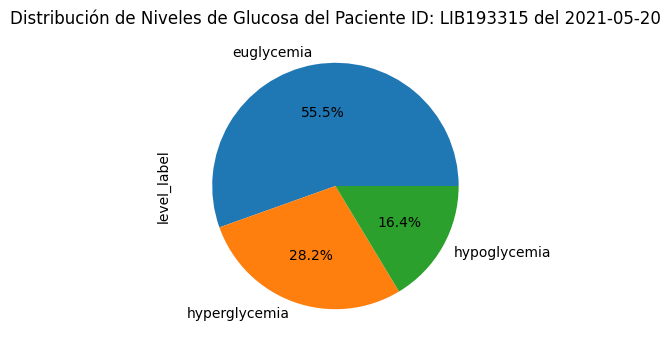

In [74]:
dateObj='2021-05-20'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP3_d2=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [75]:
df_rango.loc[dateObj+' 12:00:00':dateObj+' 13:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2021-05-20 12:00:00          103.0    12    0       2         0    euglycemia
2021-05-20 12:15:00          102.0    12   15       2         0    euglycemia
2021-05-20 12:30:00           85.0    12   30       2         0    euglycemia
2021-05-20 12:45:00           76.0    12   45       2         0    euglycemia
2021-05-20 13:00:00           67.0    13    0       3        -1  hypoglycemia

In [76]:
especialesP3.append('2021-05-20 13:00:00')

### Selección del Dia 3 del Paciente 3: ID: LIB193315

Fecha Inicio Previo  : 2021-03-13 20:30:00
Rango Inicio Objetivo: 2021-03-14 04:00:00
Rango Fin Objetivo   : 2021-03-14 23:59:59


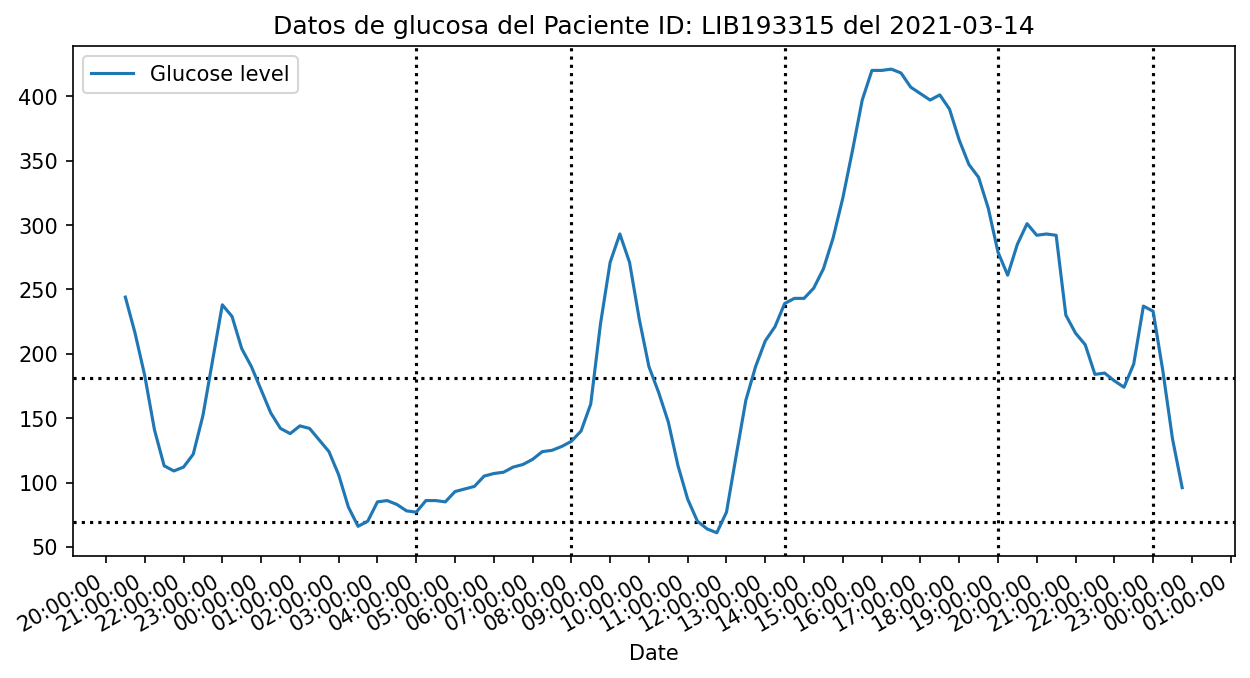

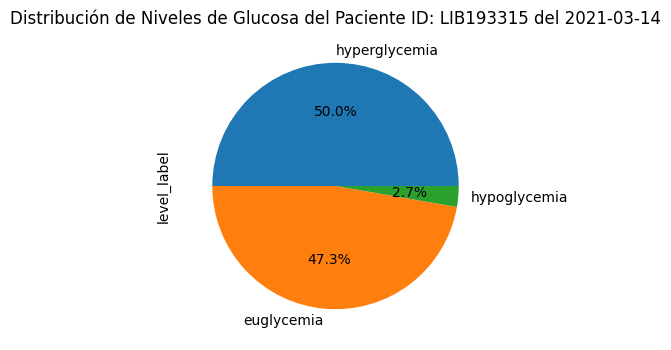

In [77]:
dateObj='2021-03-14'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP3_d3=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [78]:
df_rango.loc[dateObj+' 11:00:00':dateObj+' 12:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2021-03-14 11:00:00           87.0    11    0       2         0    euglycemia
2021-03-14 11:15:00           70.0    11   15       2         0    euglycemia
2021-03-14 11:30:00           64.0    11   30       2        -1  hypoglycemia
2021-03-14 11:45:00           61.0    11   45       2        -1  hypoglycemia
2021-03-14 12:00:00           77.0    12    0       2         0    euglycemia

In [79]:
especialesP3.append('2021-03-14 11:30:00')

### Selección del Dia 4 del Paciente 3: ID: LIB193315

Fecha Inicio Previo  : 2021-03-19 20:30:00
Rango Inicio Objetivo: 2021-03-20 04:00:00
Rango Fin Objetivo   : 2021-03-20 23:59:59


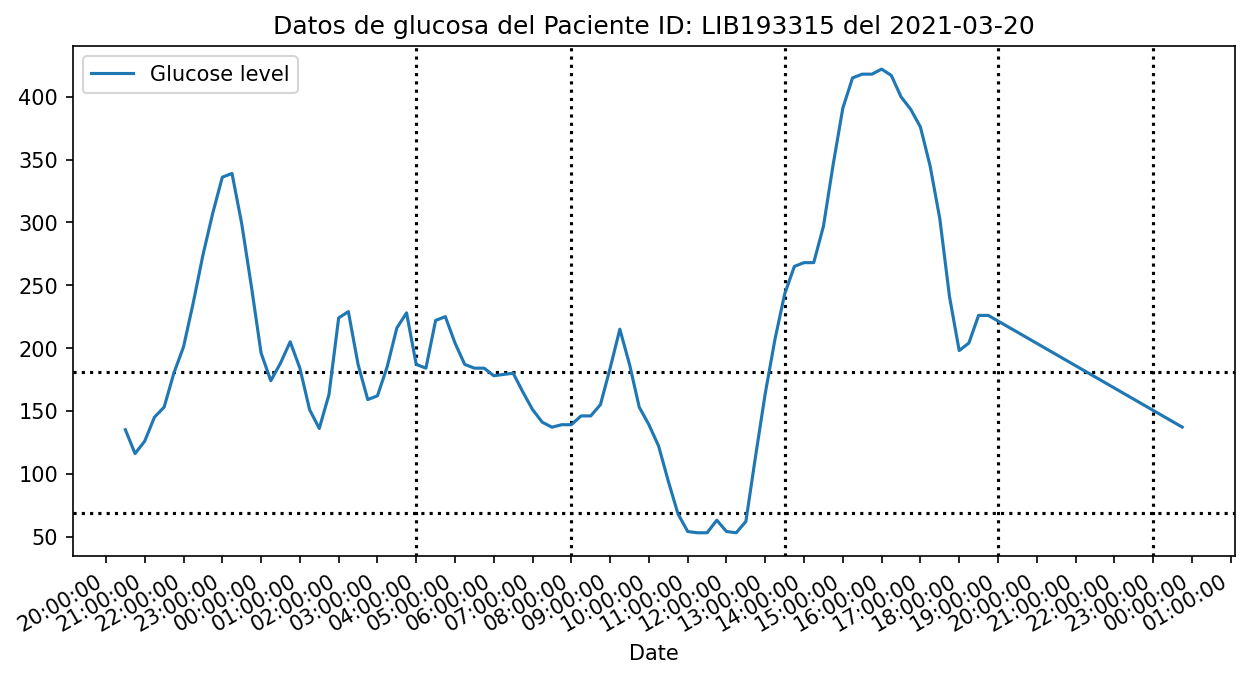

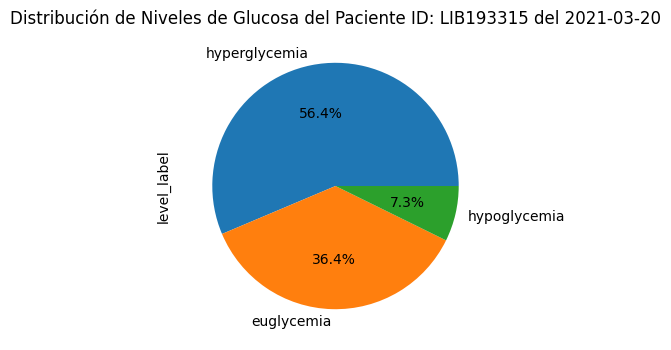

In [80]:
dateObj='2021-03-20'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP3_d4=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [81]:
df_rango.loc[dateObj+' 10:00:00':dateObj+' 11:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2021-03-20 10:00:00          139.0    10    0       2         0    euglycemia
2021-03-20 10:15:00          122.0    10   15       2         0    euglycemia
2021-03-20 10:30:00           94.0    10   30       2         0    euglycemia
2021-03-20 10:45:00           68.0    10   45       2        -1  hypoglycemia
2021-03-20 11:00:00           54.0    11    0       2        -1  hypoglycemia

In [82]:
especialesP3.append('2021-03-20 10:45:00')

In [83]:
diasP3

['2021-03-12', '2021-05-20', '2021-03-14', '2021-03-20']

In [84]:
especialesP3

['2021-03-12 22:00:00',
 '2021-05-20 13:00:00',
 '2021-03-14 11:30:00',
 '2021-03-20 10:45:00']

## Pacientes del Q4

In [85]:
dfPacienteCount[dfPacienteCount['Freq']>41868]

Freq
LIB193277  114563
LIB193385  112924
LIB193307  104043
LIB193309   77285
LIB193367   76611
LIB193269   71853
LIB193310   71764
LIB193397   68945
LIB193342   64666
LIB193356   62847
LIB193350   62830
LIB193349   60779
LIB193386   60703
LIB193314   60321
LIB193263   60069
LIB193304   59786
LIB193341   57243
LIB193371   56212
LIB193280   56057
LIB193267   55403
LIB193266   55235
LIB193332   53858
LIB193355   47929
LIB193265   46564
LIB193389   45406
LIB193327   42903
LIB193316   41946

'LIB193304' tiene 59786 muestras

In [86]:
ID_Paciente=pq4='LIB193304'


diasP4=[]
especialesP4=[]

In [87]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [88]:
dfpaciente

ID                Date  Glucose level
667394  LIB193304 2020-06-10 17:59:00          192.0
667395  LIB193304 2020-06-10 18:14:00          187.0
667396  LIB193304 2020-06-10 18:29:00          178.0
667397  LIB193304 2020-06-10 18:44:00          170.0
667398  LIB193304 2020-06-10 19:00:00          153.0
...           ...                 ...            ...
727175  LIB193304 2022-03-18 22:23:00          100.0
727176  LIB193304 2022-03-18 22:38:00           89.0
727177  LIB193304 2022-03-18 22:53:00           92.0
727178  LIB193304 2022-03-18 23:08:00          106.0
727179  LIB193304 2022-03-18 23:23:00          124.0

[59786 rows x 3 columns]

In [89]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [90]:
dfGenPaciente

Glucose level  hour  min  pod_id  level_id    level_label
Date                                                                          
2020-06-10 17:45:00          192.0    17   45       4         1  hyperglycemia
2020-06-10 18:00:00          187.0    18    0       4         1  hyperglycemia
2020-06-10 18:15:00          178.0    18   15       4         0     euglycemia
2020-06-10 18:30:00          170.0    18   30       4         0     euglycemia
2020-06-10 18:45:00          161.5    18   45       4         0     euglycemia
...                            ...   ...  ...     ...       ...            ...
2022-03-18 22:15:00          100.0    22   15       5         0     euglycemia
2022-03-18 22:30:00           89.0    22   30       5         0     euglycemia
2022-03-18 22:45:00           92.0    22   45       5         0     euglycemia
2022-03-18 23:00:00          106.0    23    0       5         0     euglycemia
2022-03-18 23:15:00          124.0    23   15       5         0     euglycemia

[62039 rows x 6 columns]

In [91]:
dfGenPacienteScaled

Glucose level      hour       min  pod_id  level_id
Date                                                                    
2020-06-10 17:45:00       0.330435  0.739130  0.762712     0.6       1.0
2020-06-10 18:00:00       0.319565  0.782609  0.000000     0.6       1.0
2020-06-10 18:15:00       0.300000  0.782609  0.254237     0.6       0.5
2020-06-10 18:30:00       0.282609  0.782609  0.508475     0.6       0.5
2020-06-10 18:45:00       0.264130  0.782609  0.762712     0.6       0.5
...                            ...       ...       ...     ...       ...
2022-03-18 22:15:00       0.130435  0.956522  0.254237     0.8       0.5
2022-03-18 22:30:00       0.106522  0.956522  0.508475     0.8       0.5
2022-03-18 22:45:00       0.113043  0.956522  0.762712     0.8       0.5
2022-03-18 23:00:00       0.143478  1.000000  0.000000     0.8       0.5
2022-03-18 23:15:00       0.182609  1.000000  0.254237     0.8       0.5

[62039 rows x 5 columns]

### Análisis del Paciente 4: ID: LIB193341

<AxesSubplot: ylabel='level_label'>

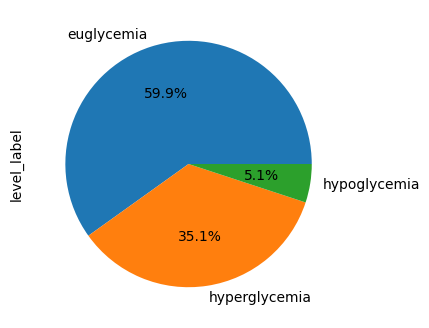

In [92]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 4: ID: LIB193304

Fecha Inicio Previo  : 2020-06-15 20:30:00
Rango Inicio Objetivo: 2020-06-16 04:00:00
Rango Fin Objetivo   : 2020-06-16 23:59:59


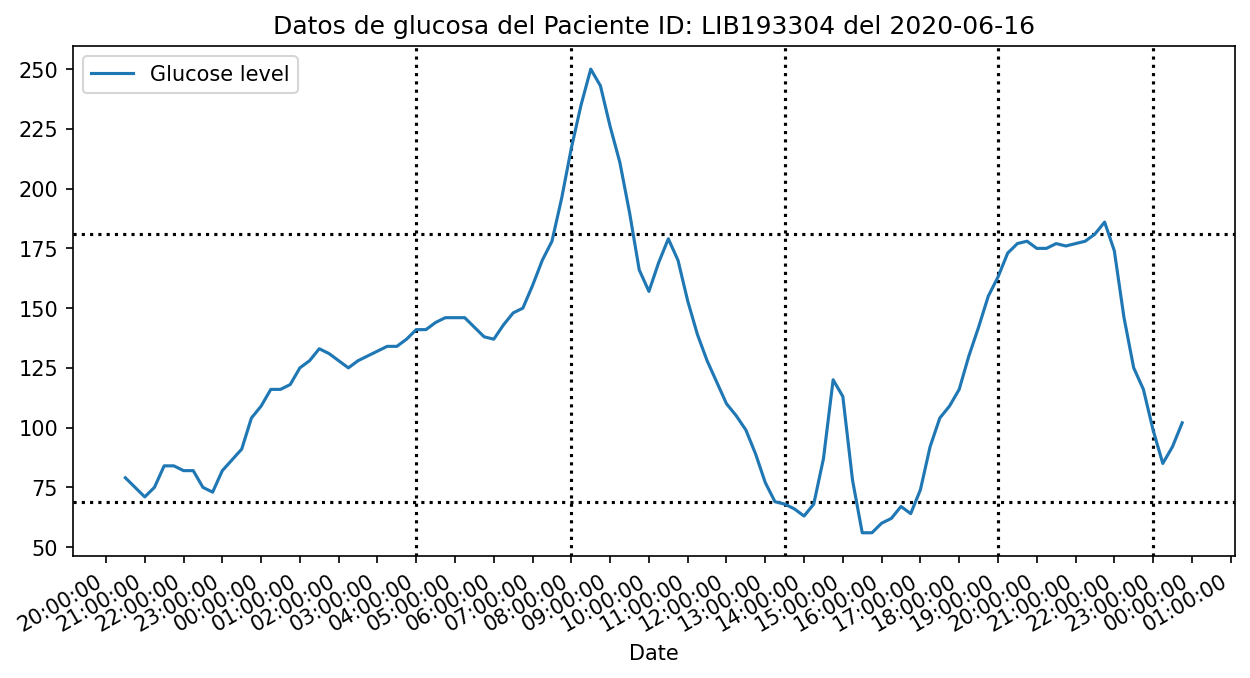

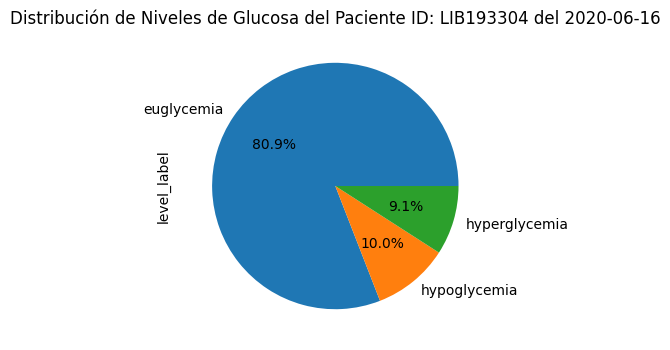

In [93]:
dateObj='2020-06-16'
diasP4.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP4_d1=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [94]:
df_rango.loc[dateObj+' 15:00:00':dateObj+' 16:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-06-16 15:00:00          113.0    15    0       3         0    euglycemia
2020-06-16 15:15:00           78.0    15   15       3         0    euglycemia
2020-06-16 15:30:00           56.0    15   30       3        -1  hypoglycemia
2020-06-16 15:45:00           56.0    15   45       3        -1  hypoglycemia
2020-06-16 16:00:00           60.0    16    0       3        -1  hypoglycemia

In [95]:
especialesP4.append('2020-06-16 15:30:00')

### Selección del Dia 2 del Paciente 4: ID: LIB193304

Fecha Inicio Previo  : 2020-07-02 20:30:00
Rango Inicio Objetivo: 2020-07-03 04:00:00
Rango Fin Objetivo   : 2020-07-03 23:59:59


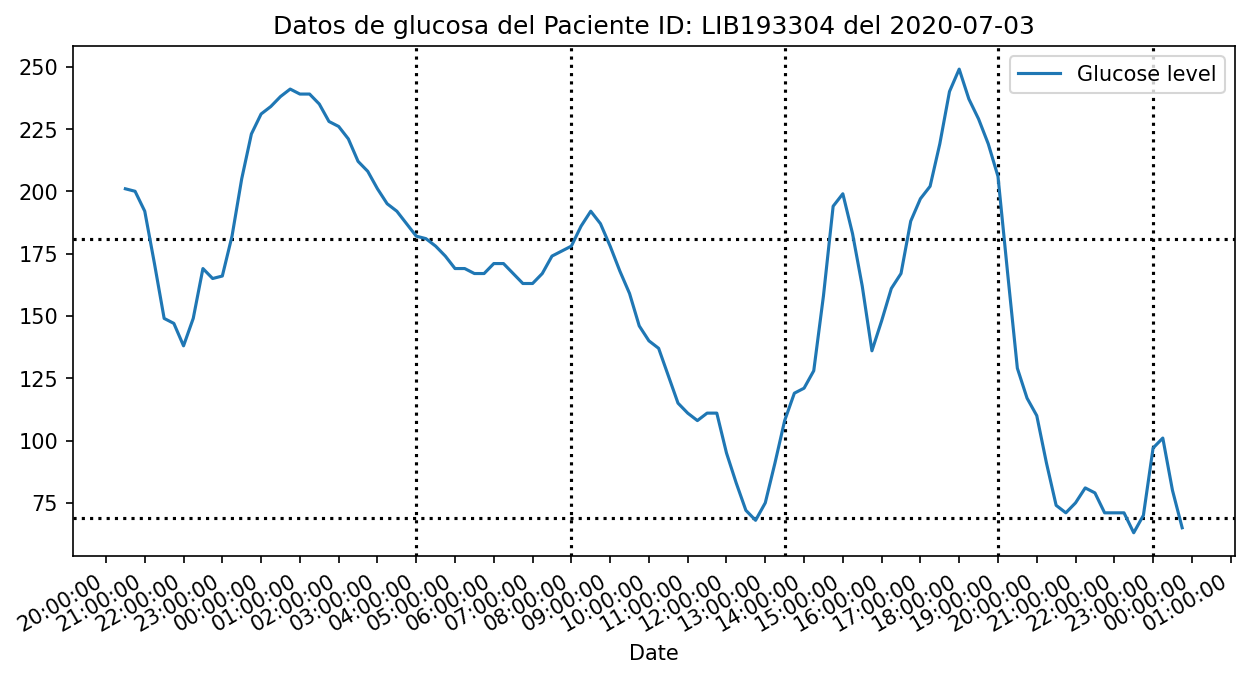

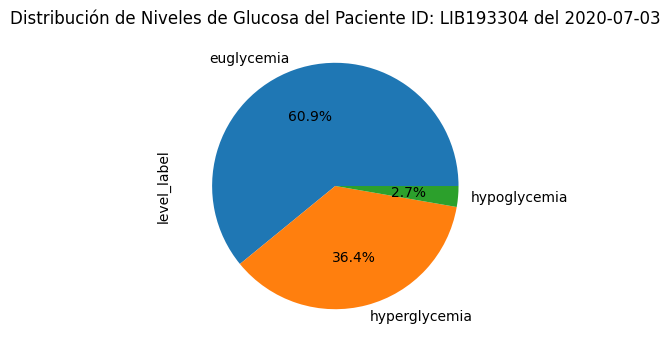

In [96]:
dateObj='2020-07-03'
diasP4.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP4_d2=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [97]:
df_rango.loc[dateObj+' 22:00:00':dateObj+' 23:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-07-03 22:00:00           71.0    22    0       5         0    euglycemia
2020-07-03 22:15:00           71.0    22   15       5         0    euglycemia
2020-07-03 22:30:00           63.0    22   30       5        -1  hypoglycemia
2020-07-03 22:45:00           70.0    22   45       5         0    euglycemia
2020-07-03 23:00:00           97.0    23    0       5         0    euglycemia

In [98]:
especialesP4.append('2020-07-03 22:30:00')

### Selección del Dia 3 del Paciente 4: ID: LIB193304

Fecha Inicio Previo  : 2020-06-17 20:30:00
Rango Inicio Objetivo: 2020-06-18 04:00:00
Rango Fin Objetivo   : 2020-06-18 23:59:59


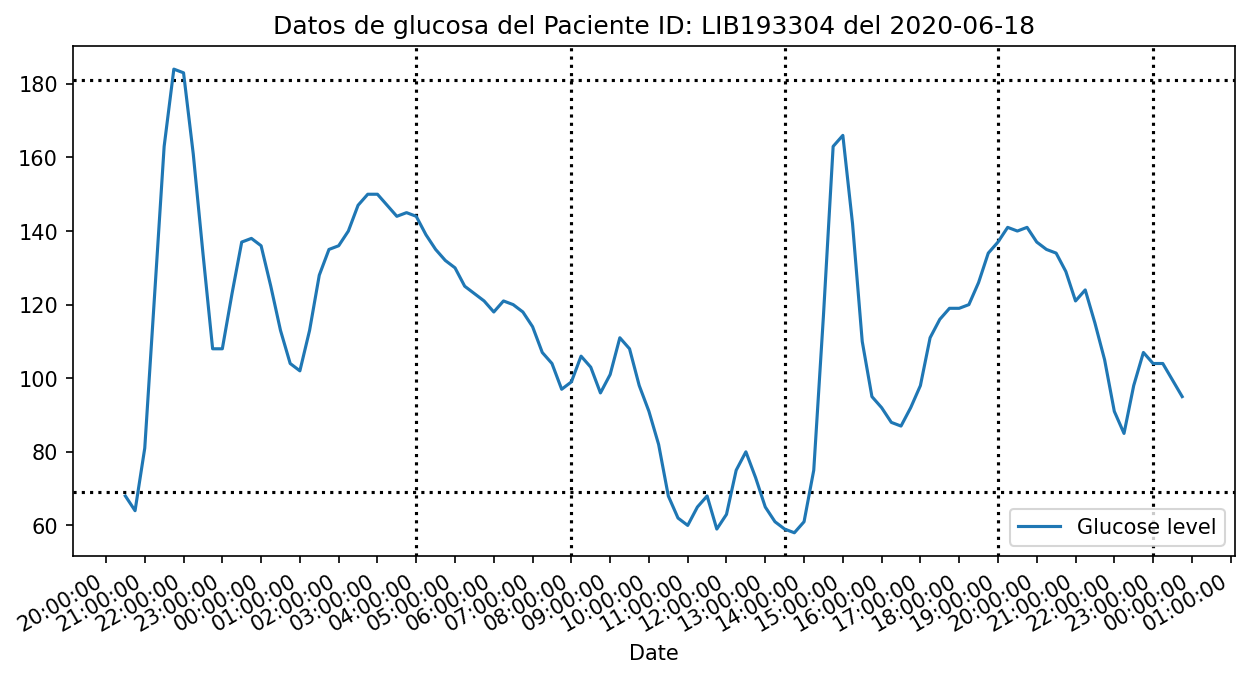

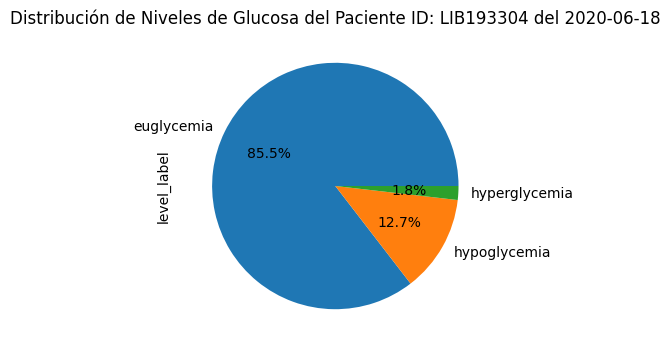

In [99]:
dateObj='2020-06-18'
diasP4.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP4_d3=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [100]:
df_rango.loc[dateObj+' 10:00:00':dateObj+' 11:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-06-18 10:00:00           91.0    10    0       2         0    euglycemia
2020-06-18 10:15:00           82.0    10   15       2         0    euglycemia
2020-06-18 10:30:00           68.0    10   30       2        -1  hypoglycemia
2020-06-18 10:45:00           62.0    10   45       2        -1  hypoglycemia
2020-06-18 11:00:00           60.0    11    0       2        -1  hypoglycemia

In [101]:
especialesP4.append('2020-06-18 10:30:00')

### Selección del Dia 4 del Paciente 4: ID: LIB193304

Fecha Inicio Previo  : 2020-06-20 20:30:00
Rango Inicio Objetivo: 2020-06-21 04:00:00
Rango Fin Objetivo   : 2020-06-21 23:59:59


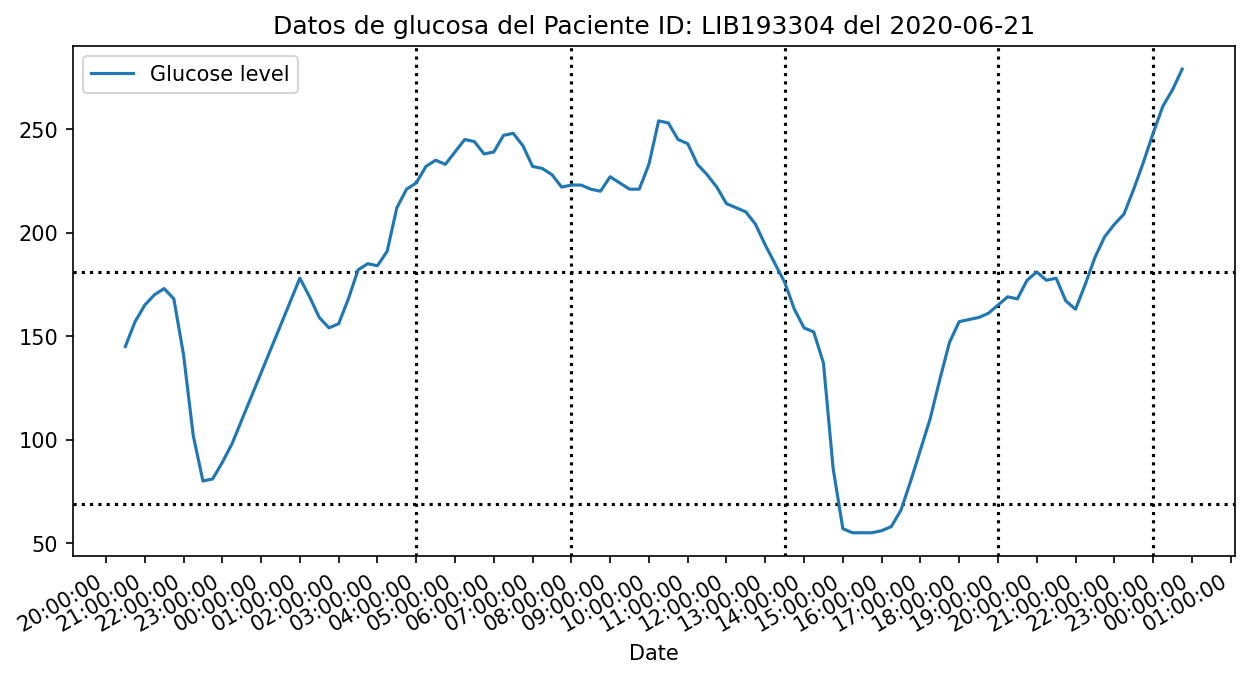

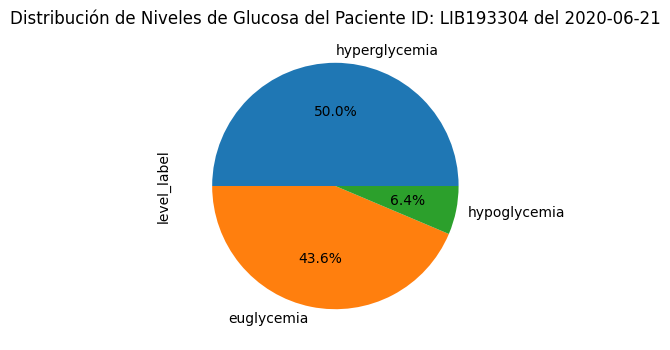

In [102]:
dateObj='2020-06-21'
diasP4.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP4_d4=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [103]:
df_rango.loc[dateObj+' 14:00:00':dateObj+' 15:00:00']

Glucose level  hour  min  pod_id  level_id   level_label
Date                                                                         
2020-06-21 14:00:00          154.0    14    0       3         0    euglycemia
2020-06-21 14:15:00          152.0    14   15       3         0    euglycemia
2020-06-21 14:30:00          137.0    14   30       3         0    euglycemia
2020-06-21 14:45:00           86.0    14   45       3         0    euglycemia
2020-06-21 15:00:00           57.0    15    0       3        -1  hypoglycemia

In [104]:
especialesP4.append('2020-06-21 15:00:00')

In [105]:
diasP4

['2020-06-16', '2020-07-03', '2020-06-18', '2020-06-21']

In [106]:
especialesP4

['2020-06-16 15:30:00',
 '2020-07-03 22:30:00',
 '2020-06-18 10:30:00',
 '2020-06-21 15:00:00']

## Unimos los dataset de los 4 dias seleccionados de cada paciente

In [107]:
dfP1 = pd.concat([dfP1_d1,dfP1_d2,dfP1_d3,dfP1_d4])
dfP2 = pd.concat([dfP2_d1,dfP2_d2,dfP2_d3,dfP2_d4])
dfP3 = pd.concat([dfP3_d1,dfP3_d2,dfP3_d3,dfP3_d4])
dfP4 = pd.concat([dfP4_d1,dfP4_d2,dfP4_d3,dfP4_d4])

## Prueba de recolección de los valores a predecir a las 4am

Hay que recordar que solo necesitamos 30 muestras hacia atras del objetivo, es decir 30*15min=450min o 7.5 horas antes

In [108]:
hora=' 04:00:00'
DateObj=diasP1[0]+hora
print(DateObj)
DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
print(DateObjStart)
df_rango=dfP1.loc[DateObjStart:DateObj]
print(len(df_rango))

2020-10-16 04:00:00
2020-10-15 20:30:00
31


In [109]:
df_rango

Glucose level      hour       min  pod_id  level_id
Date                                                                    
2020-10-15 20:30:00       0.160870  0.869565  0.508475     0.6       0.5
2020-10-15 20:45:00       0.147826  0.869565  0.762712     0.6       0.5
2020-10-15 21:00:00       0.089130  0.913043  0.000000     0.8       0.5
2020-10-15 21:15:00       0.045652  0.913043  0.254237     0.8       0.0
2020-10-15 21:30:00       0.073913  0.913043  0.508475     0.8       0.5
2020-10-15 21:45:00       0.169565  0.913043  0.762712     0.8       0.5
2020-10-15 22:00:00       0.332609  0.956522  0.000000     0.8       1.0
2020-10-15 22:15:00       0.423913  0.956522  0.254237     0.8       1.0
2020-10-15 22:30:00       0.443478  0.956522  0.508475     0.8       1.0
2020-10-15 22:45:00       0.373913  0.956522  0.762712     0.8       1.0
2020-10-15 23:00:00       0.289130  1.000000  0.000000     0.8       0.5
2020-10-15 23:15:00       0.247826  1.000000  0.254237     0.8       0.5
2020-10-15 23:30:00       0.284783  1.000000  0.508475     0.8       0.5
2020-10-15 23:45:00       0.308696  1.000000  0.762712     0.8       1.0
2020-10-16 00:00:00       0.291304  0.000000  0.000000     1.0       0.5
2020-10-16 00:15:00       0.269565  0.000000  0.254237     1.0       0.5
2020-10-16 00:30:00       0.254348  0.000000  0.508475     1.0       0.5
2020-10-16 00:45:00       0.243478  0.000000  0.762712     1.0       0.5
2020-10-16 01:00:00       0.228261  0.043478  0.000000     0.8       0.5
2020-10-16 01:15:00       0.213043  0.043478  0.254237     0.8       0.5
2020-10-16 01:30:00       0.202174  0.043478  0.508475     0.8       0.5
2020-10-16 01:45:00       0.195652  0.043478  0.762712     0.8       0.5
2020-10-16 02:00:00       0.182609  0.086957  0.000000     1.0       0.5
2020-10-16 02:15:00       0.163043  0.086957  0.254237     1.0       0.5
2020-10-16 02:30:00       0.158696  0.086957  0.508475     1.0       0.5
2020-10-16 02:45:00       0.171739  0.086957  0.762712     1.0       0.5
2020-10-16 03:00:00       0.173913  0.130435  0.000000     1.0       0.5
2020-10-16 03:15:00       0.152174  0.130435  0.254237     1.0       0.5
2020-10-16 03:30:00       0.134783  0.130435  0.508475     1.0       0.5
2020-10-16 03:45:00       0.113043  0.130435  0.762712     1.0       0.5
2020-10-16 04:00:00       0.095652  0.173913  0.000000     1.0       0.5

## Probamos como se ven los datos que debe generar para entrenamiento

In [110]:
select_data=df_rango.to_numpy()
X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)

In [111]:
X

array([[[0.16086957, 0.86956522, 0.50847458, 0.6       , 0.5       ],
        [0.14782609, 0.86956522, 0.76271186, 0.6       , 0.5       ],
        [0.08913043, 0.91304348, 0.        , 0.8       , 0.5       ],
        [0.04565217, 0.91304348, 0.25423729, 0.8       , 0.        ],
        [0.07391304, 0.91304348, 0.50847458, 0.8       , 0.5       ],
        [0.16956522, 0.91304348, 0.76271186, 0.8       , 0.5       ],
        [0.3326087 , 0.95652174, 0.        , 0.8       , 1.        ],
        [0.42391304, 0.95652174, 0.25423729, 0.8       , 1.        ],
        [0.44347826, 0.95652174, 0.50847458, 0.8       , 1.        ],
        [0.37391304, 0.95652174, 0.76271186, 0.8       , 1.        ],
        [0.28913043, 1.        , 0.        , 0.8       , 0.5       ],
        [0.24782609, 1.        , 0.25423729, 0.8       , 0.5       ],
        [0.28478261, 1.        , 0.50847458, 0.8       , 0.5       ],
        [0.30869565, 1.        , 0.76271186, 0.8       , 1.        ],
        [0.29130435,

In [112]:
Y

array([[0.09565217]])

## Recolección de los eventos de forma automática

In [113]:
gen_X=np.reshape([], (0, lag, len(featuresObj)))
gen_Y=np.reshape([], (0,1))
print(gen_X.shape)
print(gen_Y.shape)

(0, 30, 5)
(0, 1)


### Recolección de Eventos fijos

In [114]:
gen_XP1=np.reshape([], (0, lag, len(featuresObj)))
gen_YP1=np.reshape([], (0,1))

gen_XP2=np.reshape([], (0, lag, len(featuresObj)))
gen_YP2=np.reshape([], (0,1))

gen_XP3=np.reshape([], (0, lag, len(featuresObj)))
gen_YP3=np.reshape([], (0,1))

gen_XP4=np.reshape([], (0, lag, len(featuresObj)))
gen_YP4=np.reshape([], (0,1))

eventosFijos=[' 04:00:00',' 08:00:00',' 13:30:00',' 19:00:00',' 23:00:00']

eventosP1=[]
eventosP2=[]
eventosP3=[]
eventosP4=[]
for evento in eventosFijos:
    print('Paciente 1')
    for dia in diasP1: 
        DateObj=dia+evento
        print(DateObj)
        eventosP1.append(DateObj)        
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
        df_rango=dfP1.loc[DateObjStart:DateObj]
        select_data=df_rango.to_numpy()
        X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
        gen_XP1=np.concatenate((gen_XP1,X))
        gen_YP1=np.concatenate((gen_YP1,Y)) 
    
    print('Paciente 2')
    for dia in diasP2: 
        DateObj=dia+evento
        print(DateObj)
        eventosP2.append(DateObj)       
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
        df_rango=dfP2.loc[DateObjStart:DateObj]
        select_data=df_rango.to_numpy()
        X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
        gen_XP2=np.concatenate((gen_XP2,X))
        gen_YP2=np.concatenate((gen_YP2,Y)) 
    
    print('Paciente 3')
    for dia in diasP3: 
        DateObj=dia+evento
        print(DateObj)
        eventosP3.append(DateObj)       
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
        df_rango=dfP3.loc[DateObjStart:DateObj]
        select_data=df_rango.to_numpy()
        X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
        gen_XP3=np.concatenate((gen_XP3,X))
        gen_YP3=np.concatenate((gen_YP3,Y)) 
    
    print('Paciente 4')
    for dia in diasP4: 
        DateObj=dia+evento
        print(DateObj)
        eventosP4.append(DateObj)       
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
        df_rango=dfP4.loc[DateObjStart:DateObj]
        select_data=df_rango.to_numpy()
        X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
        gen_XP4=np.concatenate((gen_XP4,X))
        gen_YP4=np.concatenate((gen_YP4,Y)) 
        
print(len(gen_XP1))
print(len(gen_YP1))

print(len(gen_XP2))
print(len(gen_YP2))
print(len(gen_XP3))
print(len(gen_YP3))       

print(len(gen_XP4))
print(len(gen_YP4))

Paciente 1
2020-10-16 04:00:00
2020-10-3 04:00:00
2020-10-10 04:00:00
2020-10-12 04:00:00
Paciente 2
2020-09-29 04:00:00
2020-10-11 04:00:00
2020-10-13 04:00:00
2020-10-15 04:00:00
Paciente 3
2021-03-12 04:00:00
2021-05-20 04:00:00
2021-03-14 04:00:00
2021-03-20 04:00:00
Paciente 4
2020-06-16 04:00:00
2020-07-03 04:00:00
2020-06-18 04:00:00
2020-06-21 04:00:00
Paciente 1
2020-10-16 08:00:00
2020-10-3 08:00:00
2020-10-10 08:00:00
2020-10-12 08:00:00
Paciente 2
2020-09-29 08:00:00
2020-10-11 08:00:00
2020-10-13 08:00:00
2020-10-15 08:00:00
Paciente 3
2021-03-12 08:00:00
2021-05-20 08:00:00
2021-03-14 08:00:00
2021-03-20 08:00:00
Paciente 4
2020-06-16 08:00:00
2020-07-03 08:00:00
2020-06-18 08:00:00
2020-06-21 08:00:00
Paciente 1
2020-10-16 13:30:00
2020-10-3 13:30:00
2020-10-10 13:30:00
2020-10-12 13:30:00
Paciente 2
2020-09-29 13:30:00
2020-10-11 13:30:00
2020-10-13 13:30:00
2020-10-15 13:30:00
Paciente 3
2021-03-12 13:30:00
2021-05-20 13:30:00
2021-03-14 13:30:00
2021-03-20 13:30:00
Pa

In [115]:
gen_X=np.concatenate((gen_XP1,gen_XP2,gen_XP3,gen_XP4))

In [116]:
gen_X.shape

(80, 30, 5)

In [117]:
gen_Y=np.concatenate((gen_YP1,gen_YP2,gen_YP3,gen_YP4))

In [118]:
gen_Y.shape

(80, 1)

In [119]:
dfResult=pd.DataFrame(scalerGlucosa.inverse_transform(gen_Y),columns=['Glucose level'])
dfResult['Nivel'] = dfResult['Glucose level'].apply(utils.label_LevelBG)   
dfResult

Glucose level          Nivel
0            84.0     euglycemia
1           191.0  hyperglycemia
2           199.0  hyperglycemia
3            80.0     euglycemia
4            99.0     euglycemia
..            ...            ...
75          165.0     euglycemia
76           99.0     euglycemia
77           97.0     euglycemia
78          104.0     euglycemia
79          248.0  hyperglycemia

[80 rows x 2 columns]

In [120]:
dfResult['Nivel'].value_counts()

euglycemia       47
hyperglycemia    23
hypoglycemia     10
Name: Nivel, dtype: int64

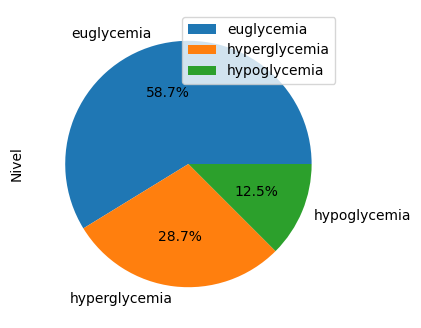

In [121]:
dfResult['Nivel'].value_counts().plot.pie(y='level_label',legend=True,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

In [122]:
print('Paciente 1')
for evento in especialesP1:    
    DateObj=evento
    print(DateObj)
    eventosP1.append(DateObj)       
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP1.loc[DateObjStart:DateObj]
    select_data=df_rango.to_numpy()
    X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
    gen_XP1=np.concatenate((gen_XP1,X))
    gen_YP1=np.concatenate((gen_YP1,Y)) 
    
print('Paciente 2')
for evento in especialesP2:    
    DateObj=evento
    print(DateObj)
    eventosP2.append(DateObj)       
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP2.loc[DateObjStart:DateObj]
    select_data=df_rango.to_numpy()
    X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
    gen_XP2=np.concatenate((gen_XP2,X))
    gen_YP2=np.concatenate((gen_YP2,Y))
     
print('Paciente 3')
for evento in especialesP3:    
    DateObj=evento
    print(DateObj)
    eventosP3.append(DateObj)       
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP3.loc[DateObjStart:DateObj]
    select_data=df_rango.to_numpy()
    X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
    gen_XP3=np.concatenate((gen_XP3,X))
    gen_YP3=np.concatenate((gen_YP3,Y)) 
 
    
print('Paciente 4')
for evento in especialesP4:    
    DateObj=evento
    print(DateObj)
    eventosP4.append(DateObj)       
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP4.loc[DateObjStart:DateObj]
    select_data=df_rango.to_numpy()
    X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
    gen_XP4=np.concatenate((gen_XP4,X))
    gen_YP4=np.concatenate((gen_YP4,Y)) 
    
print(len(gen_XP1))
print(len(gen_YP1))

print(len(gen_XP2))
print(len(gen_YP2))
print(len(gen_XP3))
print(len(gen_YP3))       

print(len(gen_XP4))
print(len(gen_YP4))

Paciente 1
2020-10-16 17:45:00
2020-10-03 21:00:00
2020-10-10 19:45:00
2020-10-12 06:30:00
Paciente 2
2020-09-29 14:30:00
2020-10-11 14:00:00
2020-10-13 14:15:00
2020-10-15 18:00:00
Paciente 3
2021-03-12 22:00:00
2021-05-20 13:00:00
2021-03-14 11:30:00
2021-03-20 10:45:00
Paciente 4
2020-06-16 15:30:00
2020-07-03 22:30:00
2020-06-18 10:30:00
2020-06-21 15:00:00
24
24
24
24
24
24
24
24


In [123]:
gen_Y_Especiales=np.concatenate((gen_YP1,gen_YP2,gen_YP3,gen_YP4))

In [124]:
gen_Y_Especiales.shape

(96, 1)

In [125]:
genT_Total=np.concatenate((gen_Y,gen_Y_Especiales))

In [126]:
genT_Total.shape

(176, 1)

In [127]:
dfResult=pd.DataFrame(scalerGlucosa.inverse_transform(genT_Total),columns=['Glucose level'])
dfResult['Nivel'] = dfResult['Glucose level'].apply(utils.label_LevelBG)   
dfResult['Nivel'].value_counts()

euglycemia       95
hyperglycemia    46
hypoglycemia     35
Name: Nivel, dtype: int64

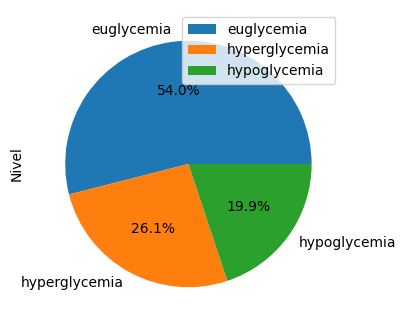

In [128]:
dfResult['Nivel'].value_counts().plot.pie(y='level_label',legend=True,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

In [129]:
dump(eventosP1, open('dataset/generado/paciente1/eventos.list', 'wb'))
print(len(eventosP1))

24


In [130]:
dump(eventosP2, open('dataset/generado/paciente2/eventos.list', 'wb'))
print(len(eventosP2))

24


In [131]:
dump(eventosP3, open('dataset/generado/paciente3/eventos.list', 'wb'))
print(len(eventosP3))

24


In [132]:
dump(eventosP4, open('dataset/generado/paciente4/eventos.list', 'wb'))
print(len(eventosP4))

24


## Guardamos los IDs de los pacientes para modelo general

In [134]:
dfPacienteCount

Freq
LIB193277  114563
LIB193385  112924
LIB193307  104043
LIB193309   77285
LIB193367   76611
...           ...
LIB193282    1808
LIB193366    1287
LIB193398    1253
LIB193283    1098
LIB193365    1057

[107 rows x 1 columns]

In [138]:
pacientesEvaluacion=[pq1,pq2,pq3,pq4]
dfPacienteCount=dfPacienteCount[~dfPacienteCount.index.isin(pacientesEvaluacion)]
dfPacienteCount['ID']=dfPacienteCount.index
dfPacienteCount

Freq         ID
LIB193277  114563  LIB193277
LIB193385  112924  LIB193385
LIB193307  104043  LIB193307
LIB193309   77285  LIB193309
LIB193367   76611  LIB193367
...           ...        ...
LIB193282    1808  LIB193282
LIB193366    1287  LIB193366
LIB193398    1253  LIB193398
LIB193283    1098  LIB193283
LIB193365    1057  LIB193365

[103 rows x 2 columns]

In [139]:
dfPacienteCount['ID'].to_csv('dataset/generado/IDs_ModelGen.csv', index=False) 